<a href="https://colab.research.google.com/github/Strugoeden121/DataScience236006-Final/blob/main/proj_eden_edu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
#Load the csv file of the adult-income-dataset csv adult.csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the adult dataset
adult_dataset = pd.read_csv('./adult.csv')

In [101]:
# Drop all the columns that are not in the relevant features
relevant_features = ['age', 'gender', 'race', 'native-country', 'income']
adult_dataset = adult_dataset[[col for col in adult_dataset.columns if col in relevant_features]]

# Replace missing values denoted by '?' with NaN
adult_dataset.replace('?', np.nan, inplace=True)

# Drop rows with missing values
adult_dataset.dropna(inplace=True)

# Reset index after dropping rows
adult_dataset.reset_index(drop=True, inplace=True)

# Display the first few rows
print(adult_dataset.head())

   age   race  gender native-country income
0   25  Black    Male  United-States  <=50K
1   38  White    Male  United-States  <=50K
2   28  White    Male  United-States   >50K
3   44  Black    Male  United-States   >50K
4   18  White  Female  United-States  <=50K


### Find Underrepresented groups
#### We will check for a two feature combinations from: 'race', 'native-country', 'gender', 'age'

In [102]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

def plot_heatmap_categorical(data, value1, value2):
    # Create a cross-tabulation of the two categorical values
    crosstab = pd.crosstab(data[value1], data[value2])

    # Calculate the frequency of each category
    freq = crosstab.apply(lambda r: r / r.sum(), axis=1)

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    if len(crosstab.columns) > 5:
        num_subplots = len(crosstab.columns) // 5 + 1
        fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 6*num_subplots))
        for i in range(num_subplots):
            start_idx = i * 5
            end_idx = min((i + 1) * 5, len(crosstab.columns))
            sub_crosstab = crosstab.iloc[:, start_idx:end_idx]
            ax = axes[i] if num_subplots > 1 else axes
            sns.heatmap(sub_crosstab, annot=True, fmt='d', cmap='RdBu', linewidths=0.5, linecolor='white', ax=ax, vmin=crosstab.min().min(), vmax=crosstab.max().max())
            ax.set_title(f'Counts of {value1} and {value2} (Part {i+1})')
            ax.set_xlabel(value2)
            ax.set_ylabel(value1)
        plt.tight_layout()
    else:
        sns.heatmap(crosstab, annot=True, fmt='d', cmap='RdBu', linewidths=0.5, linecolor='white', vmin=crosstab.min().min(), vmax=crosstab.max().max())
        plt.title(f'Counts of {value1} and {value2}')
        plt.xlabel(value2)
        plt.ylabel(value1)
    plt.show()

Find Underrepresented groups for race and gender

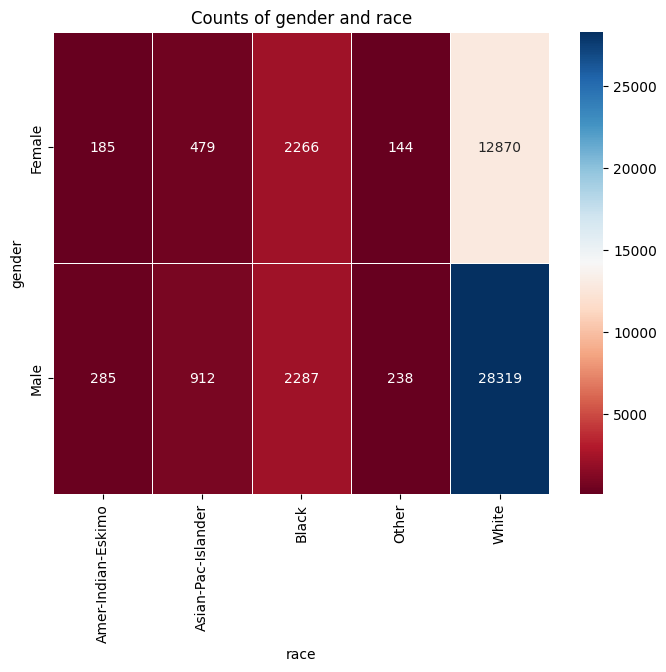

In [103]:
plot_heatmap_categorical(adult_dataset, 'gender', 'race')

We see general underrepresentation for Amer-Indian-Eskimo.
We also see underrepresentation for female Asian-Pac-Islander

<Figure size 800x600 with 0 Axes>

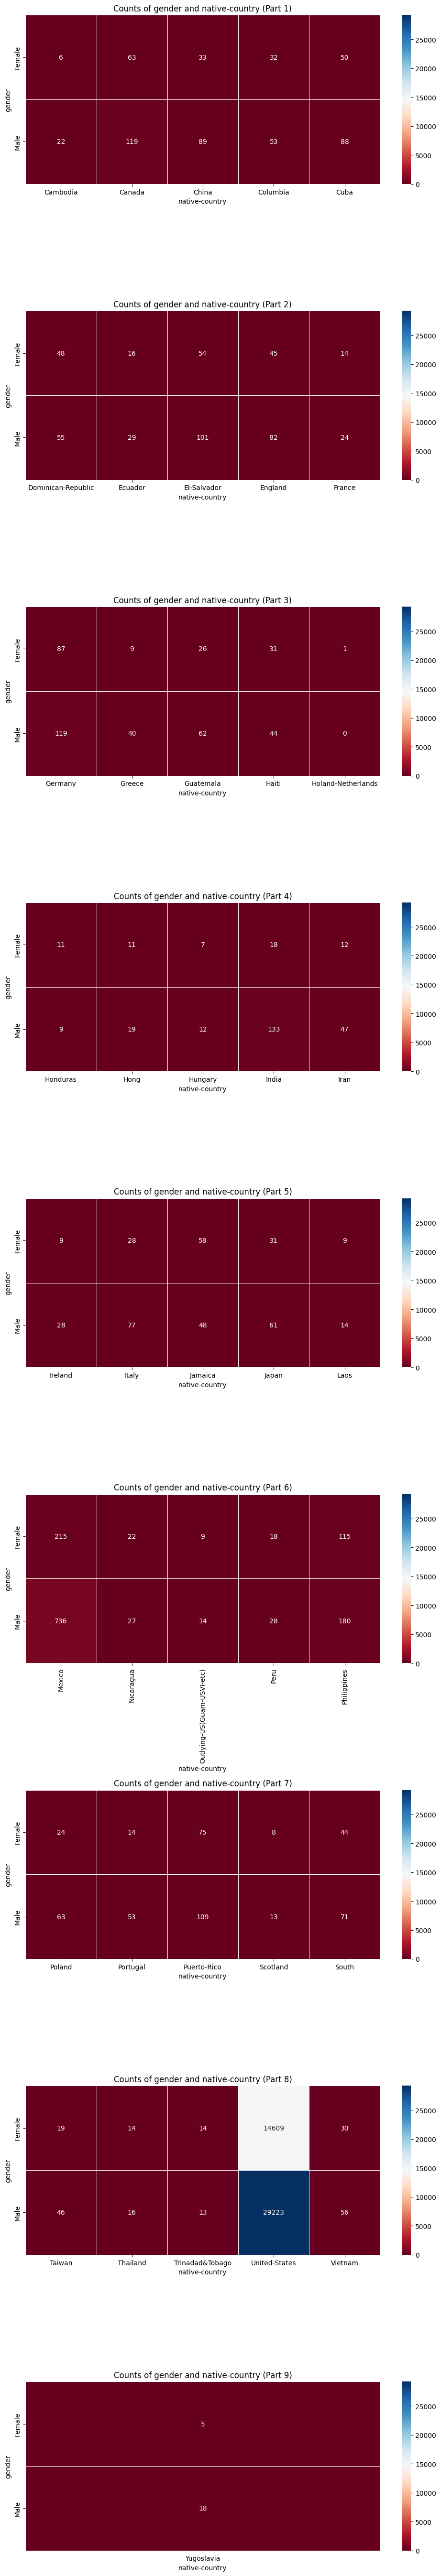

In [104]:
plot_heatmap_categorical(adult_dataset, 'gender', 'native-country')

We see that the United States is the most common native-country and it makes hard to understand the heatmap.
Lets understand if in general non-United-States is underrepresented.

In [105]:
# Calculate the pretcentage of non US citizens
non_us_citizens = adult_dataset[adult_dataset['native-country'] != 'United-States']
percentage = len(non_us_citizens) / len(adult_dataset) * 100
print(f'{percentage:.2f}% of the dataset are non US citizens')
print(f'the number of non US citizens is {len(non_us_citizens)}')

8.65% of the dataset are non US citizens
the number of non US citizens is 4153


There are 3930 non-US citizens samples in the data, which are 8.69%. For now we are not considering this entire category as underrepresented.
And so we now will enlarge the resolution.

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


<Figure size 800x600 with 0 Axes>

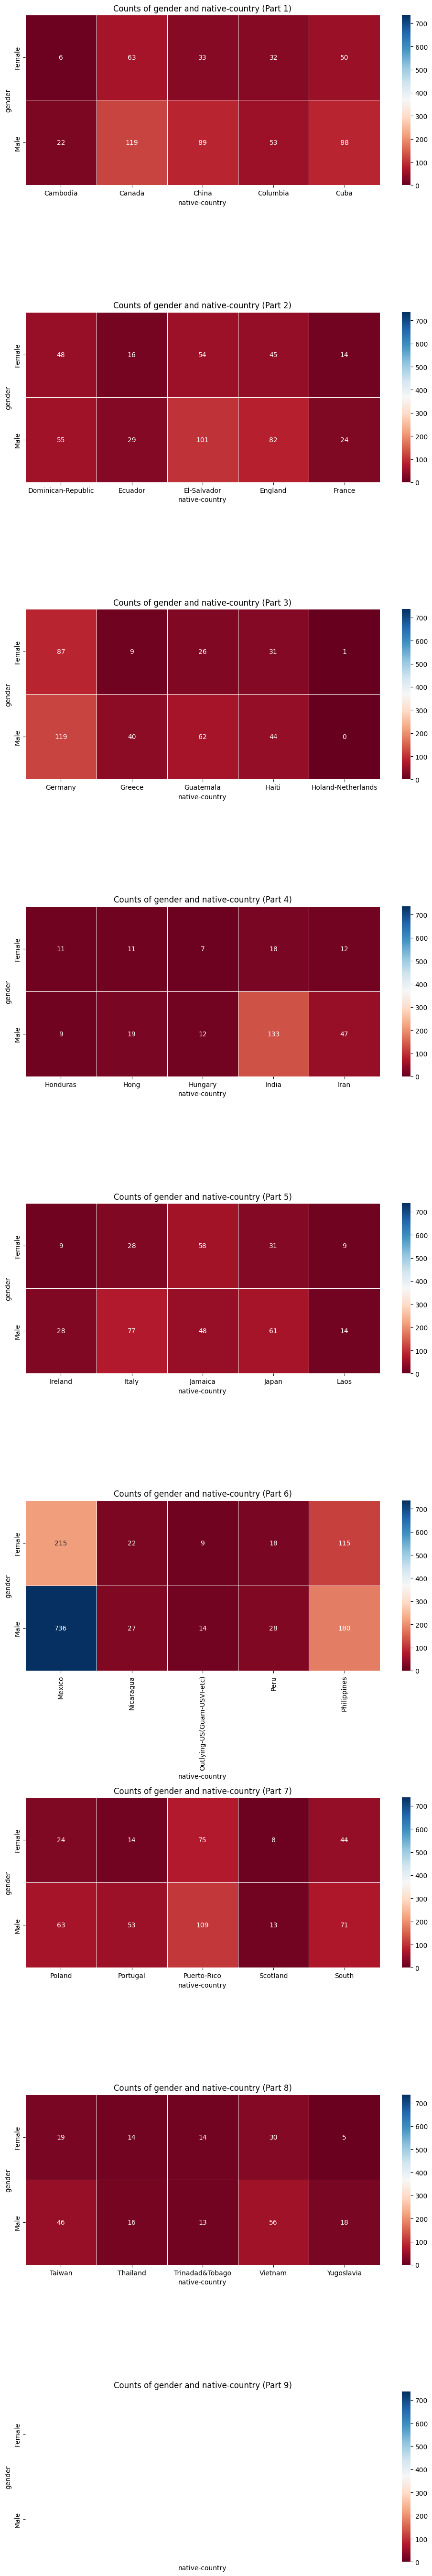

In [106]:
plot_heatmap_categorical(non_us_citizens, 'gender', 'native-country')

It is obvious now that each native-country other than the US (and maybe Mexico) can be considered underrepresented.
We will explore two options to continue.
The first is binning native-country into continents
The second is defining those all as underrepresented when synthesizing the new samples, and prompt the LLM to create samples for all non-US native-countries.

Because the native-countries is so split, we will move forward with the bins for now, especially when trying to find underrepresentation

In [107]:
def map_country_to_continent(country):
    continent_map = {
        'North America': ['United-States', 'Canada', 'Mexico','Outlying-US(Guam-USVI-etc)',],
        'Central America': [ 'Puerto-Rico', 'Honduras', 'Cuba', 'Dominican-Republic', 'Jamaica', 'El-Salvador', 'Haiti', 'Trinadad&Tobago'],
        'Asia': ['China', 'India', 'Japan', 'Philippines', 'Vietnam', 'South'],
        'Europe': ['England', 'Germany', 'Italy', 'Poland', 'Portugal', 'France', 'Greece', 'Ireland'],
        'South America': ['Columbia', 'Ecuador', 'Peru']
    }

    for continent, countries in continent_map.items():
        if country in countries:
            return continent
    return 'Other'

adult_dataset['continent'] = adult_dataset['native-country'].apply(map_country_to_continent)

<Figure size 800x600 with 0 Axes>

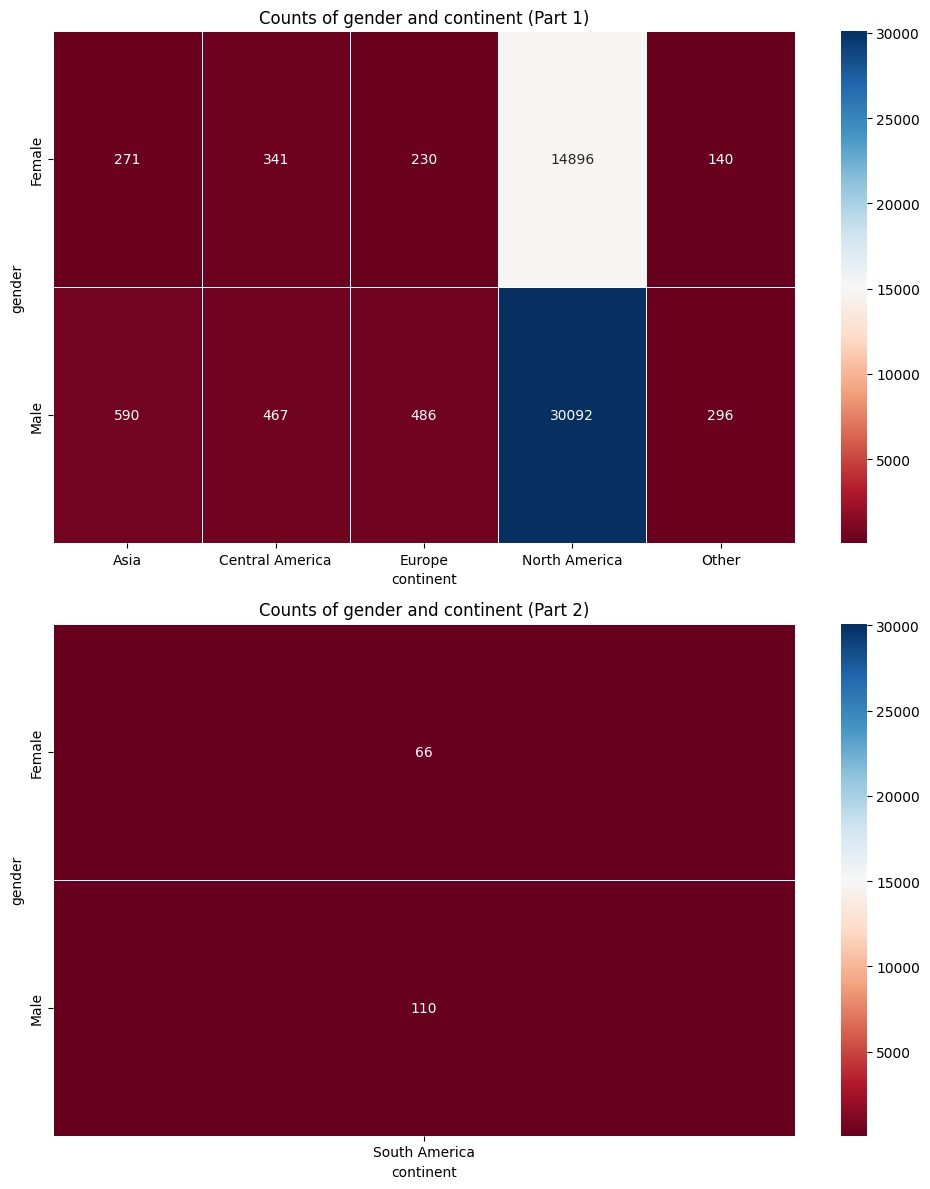

In [108]:
plot_heatmap_categorical(adult_dataset, 'gender', 'continent')

We again see that the US (North America) is by far the most represented, even after binning into continents.
We will remove the North-America like we did before to better visualize the data

<ipython-input-109-5418bf380d88>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_us_citizens['continent'] = non_us_citizens['native-country'].apply(map_country_to_continent)


<Figure size 800x600 with 0 Axes>

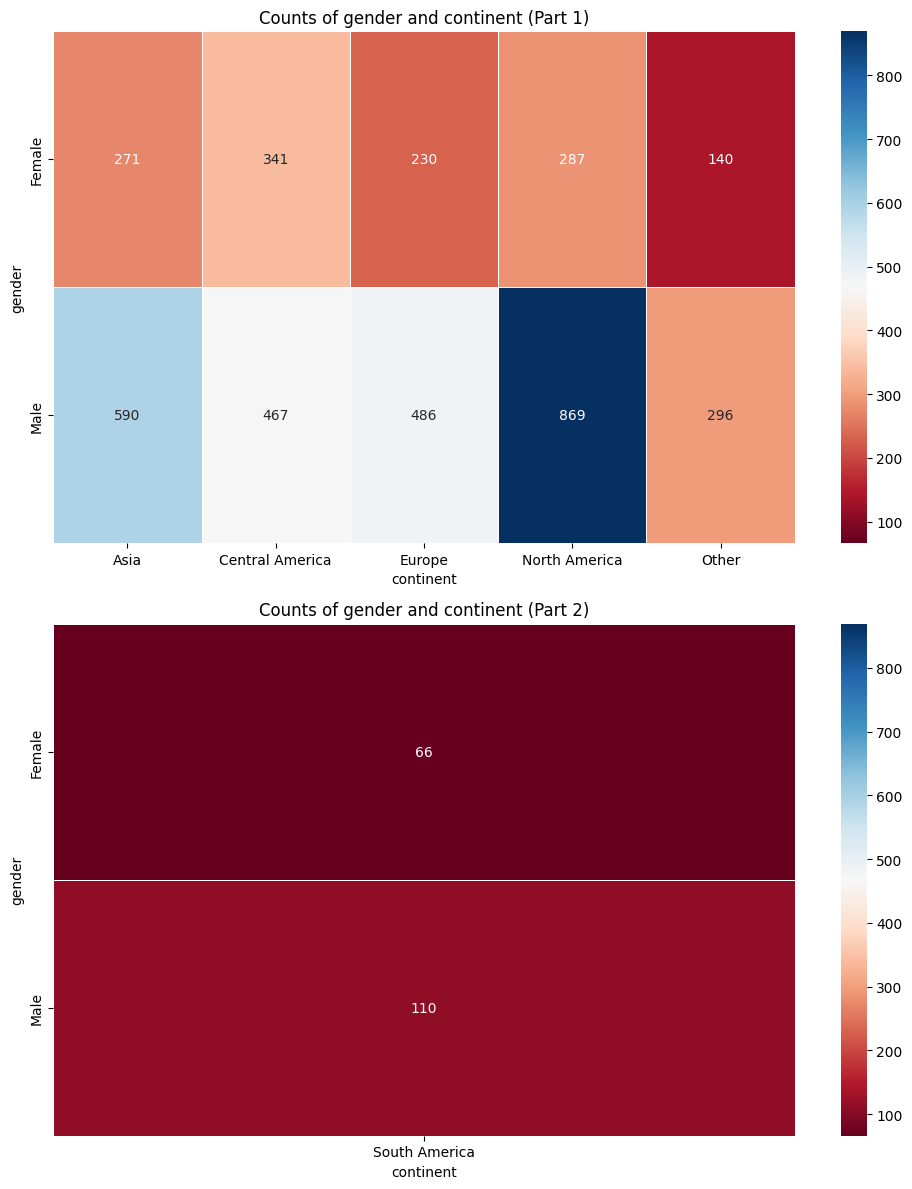

In [109]:
non_us_citizens['continent'] = non_us_citizens['native-country'].apply(map_country_to_continent)
plot_heatmap_categorical(non_us_citizens, 'gender', 'continent')

We now see that South America is the underrepresented continent.
There is not much of a difference there between male and Female. And so we conclude that the entire South America continent as underrepresented


We will now check for race and continent

<Figure size 800x600 with 0 Axes>

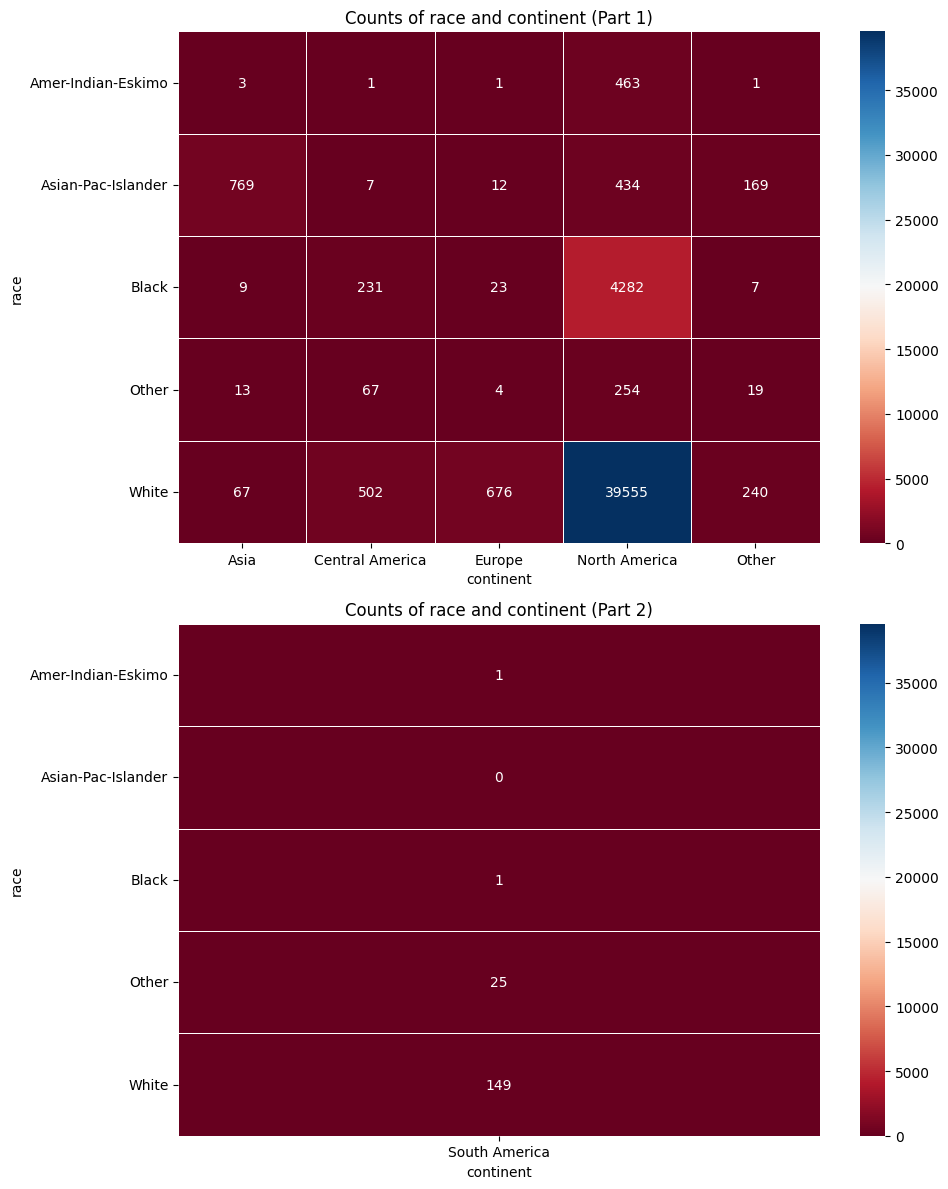

In [110]:
plot_heatmap_categorical(adult_dataset, 'race', 'continent')

We see that Asia white peaple and Asia black people are underrepresented!

We will now check underrepresented groups for age combinations.
We will first bin the age to categories

In [111]:
# Bin the age column into different age groups that are more interpretable and meaningful in regards to income
kids_range = range(0, 18)
young_adults_range = range(18, 30)
adults_range = range(30, 50)
middle_aged_range = range(50, 65)
senior_range = range(65, 100)

def map_age_to_group(age):
    if age in kids_range:
        return 'Kids'
    elif age in young_adults_range:
        return 'YoungAdults'
    elif age in adults_range:
        return 'Adults'
    elif age in middle_aged_range:
        return 'MiddleAged'
    elif age in senior_range:
        return 'Senior'
    else:
        return 'Other'

adult_dataset['agegroup'] = adult_dataset['age'].apply(map_age_to_group)

adult_dataset.drop(['age', 'native-country'], axis=1, inplace=True)

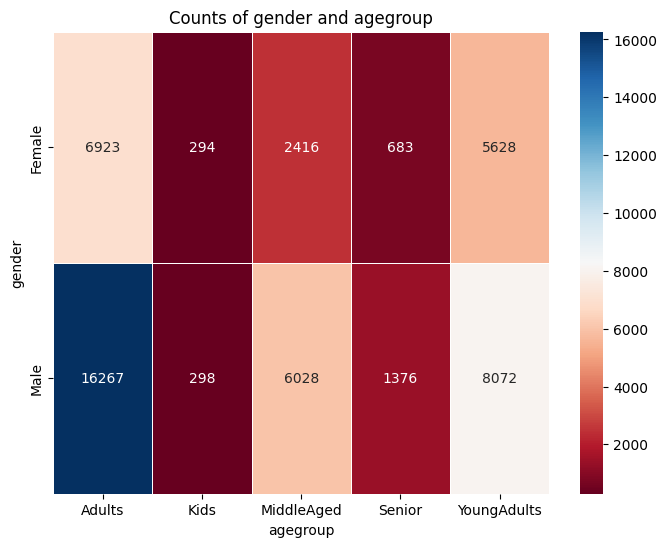

In [112]:
plot_heatmap_categorical(adult_dataset, 'gender', 'agegroup')

We found no underrepresented group. Now we will check for age and race

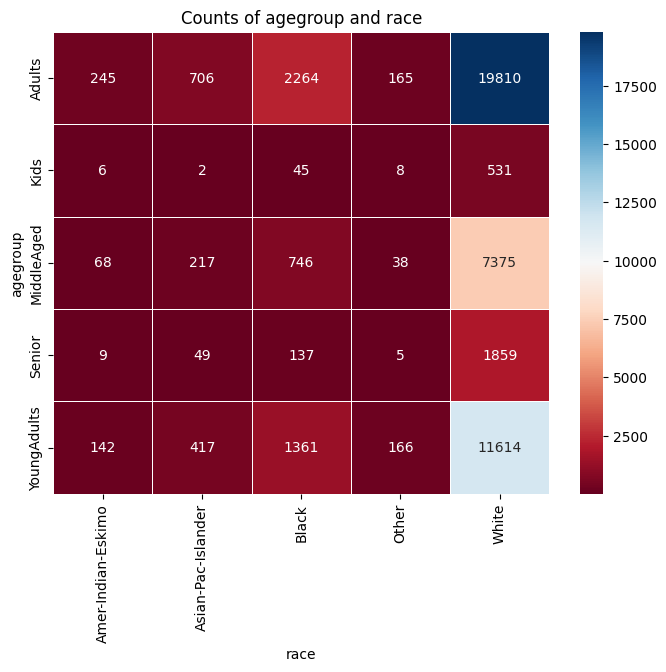

In [113]:
plot_heatmap_categorical(adult_dataset, 'agegroup', 'race')

We see underrepresentation for all non-white kids! (448 white kids vs 45 non white kids). meaning non-white kids are only 0.1% of the data.

<Figure size 800x600 with 0 Axes>

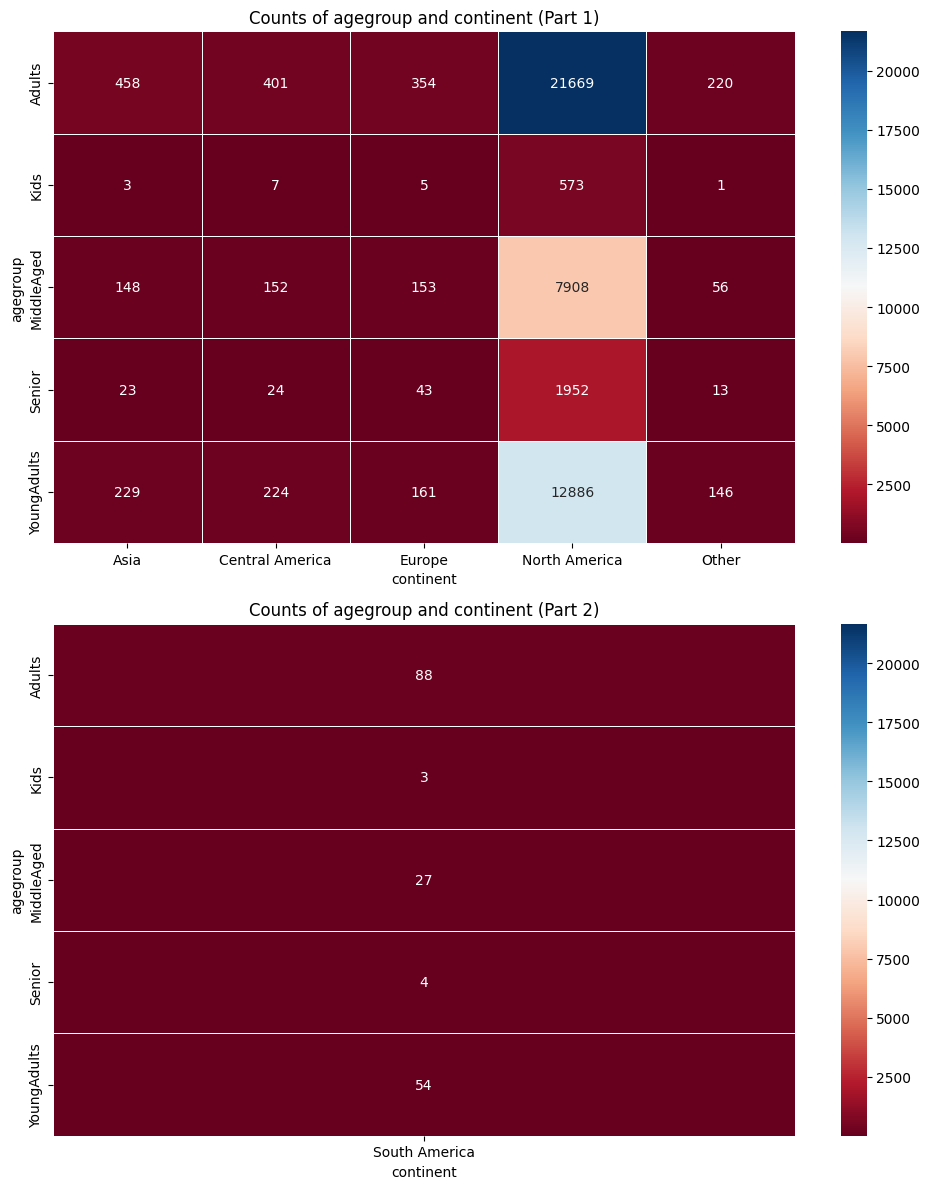

In [114]:
plot_heatmap_categorical(adult_dataset, 'agegroup', 'continent')

We see that seniors that aren't North America are underrepresented. We can take Asia-Seniors as an underrepresentred group.

We found underrepresented groups. We will now calculate the weights of the causal dag containing only the agegroup, continent, race, gender and income nodes.

5 5
True


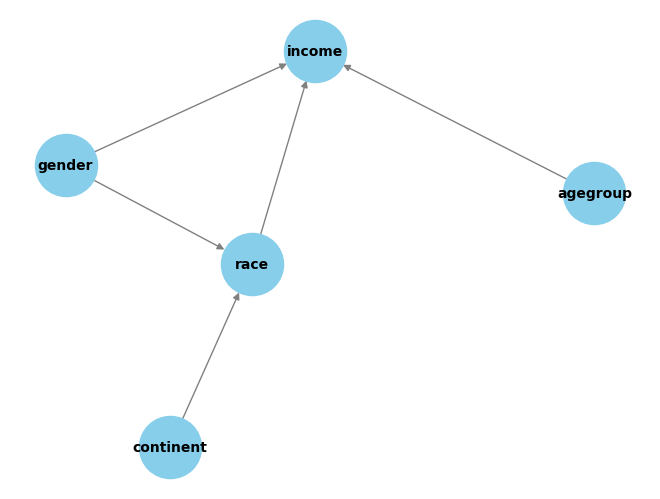

In [115]:
import networkx as nx

dag_data = [
    ('age', 'education_num'),
    ('age', 'hours_per_week'),
    ('age', 'income'),
    ('age', 'income'),
    ('age', 'marital_status'),
    ('age', 'marital_status'),
    ('age', 'occupation'),
    ('age', 'relationship'),
    ('age', 'work_class'),
    ('education_num', 'education'),
    ('education_num', 'hours_per_week'),
    ('education_num', 'income'),
    ('education_num', 'income'),
    ('education_num', 'occupation'),
    ('education_num', 'work_class'),
    ('education_num', 'work_class'),
    ('hours_per_week', 'income'),
    ('hours_per_week', 'relationship'),
    ('income', 'education'),
    ('marital_status', 'education_num'),
    ('marital_status', 'hours_per_week'),
    ('marital_status', 'income'),
    ('marital_status', 'occupation'),
    ('marital_status', 'work_class'),
    ('marital_status', 'work_class'),
    ('native-countryountry', 'education'),
    ('native-countryountry', 'education_num'),
    ('native-countryountry', 'education_num'),
    ('native-countryountry', 'hours_per_week'),
    ('native-countryountry', 'income'),
    ('native-country', 'marital_status'),
    ('native-country', 'occupation'),
    ('native-country', 'race'),
    ('native-country', 'work_class'),
    ('occupation', 'education'),
    ('occupation', 'income'),
    ('occupation', 'occupation_category'),
    ('occupation_category', 'education'),
    ('occupation_category', 'work_class'),
    ('race', 'education_num'),
    ('race', 'hours_per_week'),
    ('race', 'income'),
    ('race', 'income'),
    ('race', 'marital_status'),
    ('race', 'occupation'),
    ('race', 'work_class'),
    ('race', 'work_class'),
    ('gender', 'education_num'),
    ('gender', 'hours_per_week'),
    ('gender', 'income'),
    ('gender', 'income'),
    ('gender', 'marital_status'),
    ('gender', 'occupation'),
    ('gender', 'race'),
    ('gender', 'relationship'),
    ('gender', 'work_class'),
    ('gender', 'work_class'),
    ('work_class', 'income'),
]

# keep only unique tuples
dag_data = list(set(dag_data))
# keep only tupples with both nodes conatained in the features: [age, gender, race, native-country, income]
dag_data = [row for row in dag_data if row[0] in relevant_features and row[1] in relevant_features]
# rename native-country to continent and age to agegroup
dag_data = [(row[0].replace('native-country', 'continent').replace('age', 'agegroup'), row[1].replace('native-country', 'continent').replace('age', 'agegroup')) for row in dag_data]

outcome_node = 'income'
treatment_node_to_possible_treatments = {
    'agegroup': ['YoungAdults', 'Adults', 'MiddleAged', 'Senior', 'Kids'],
    'continent': ['North America', 'Central America', 'Asia', 'Europe', 'South America', 'Other'],
    'race': ['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other'],
    'gender': ['Male', 'Female']}
    # 'income': ['<=50K', '>50K']}

# categorical_cols = ['agegroup', 'continent', 'race', 'gender', 'income']
# print()
# # convert the categorical columns to one-hot encoding
# adult_dataset = pd.get_dummies(adult_dataset, columns=categorical_cols, drop_first=True)
# for dag_data_edge in dag_data:
#     if dag_data_edge[0] in categorical_cols:
#         dag_data += [(f'{dag_data_edge[0]}_{treatment}', dag_data_edge[1]) for treatment in treatment_node_to_possible_treatments[dag_data_edge[0]]]
#     if dag_data_edge[1] in categorical_cols:
#         dag_data += [(dag_data_edge[0], f'{dag_data_edge[1]}_{treatment}') for treatment in treatment_node_to_possible_treatments[dag_data_edge[1]]]

# edit the dag to include the one-hot encoded columns
dag = nx.DiGraph(dag_data)
print(len(dag.nodes), len(dag.edges))

print(nx.is_directed_acyclic_graph(dag))
# Draw the dag

nx.draw(dag, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray', pos=nx.spring_layout(dag))

In [116]:
!pip install dowhy

In [117]:
# For each node in the DAG, calculate the ATE of each possible treatment on the income feature, using dowhy
import dowhy
from dowhy import CausalModel
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

def is_treatment_significant(causal_estimate):
    p_value = causal_estimate.test_stat_significance()['p_value']
    # try :
    return p_value is not None and p_value < 0.05
    # except:
    #     return p_value[0] < 0.05


def get_treatment_to_casual_estimate_dict(origin_dataset, dag, treatment_node_to_possible_treatments):
    # change the income column to binary
    adult_dataset = origin_dataset.copy()
    adult_dataset['income'] = adult_dataset['income'].apply(lambda x: 1 if x == '>50K' else -1)
    treatment_to_casual_estimate_dict = {}
    for treatment_node, possible_treatments in treatment_node_to_possible_treatments.items():
        for treatment in possible_treatments:
            dataset = adult_dataset.copy()
            dataset[treatment_node] = dataset[treatment_node].apply(lambda x: 1 if x == treatment else 0)
            # print the number of rows for each treatment
            print(f'{treatment_node}={treatment} : {len(dataset[dataset[treatment_node] == 1])}')
            print(f'{treatment_node}!= {treatment} : {len(dataset[dataset[treatment_node] == 0])}')
            model = CausalModel(
                data=dataset,
                treatment=treatment_node,
                outcome=outcome_node,
                graph=dag
            )
            identified_estimand = model.identify_effect()
            causal_estimate = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.linear_regression",
                                            target_units="ate",
                                            effect_modifiers = [],
                                            test_significance=True,
                                            )
            # check if the treatment is significant
            if is_treatment_significant(causal_estimate):
                print(f'Treatment: {treatment_node}={treatment}, ATE: {causal_estimate.value}')
            else :
                print(f'Treatment: {treatment_node}={treatment}, ATE: Not significant, p-value: {causal_estimate.test_stat_significance()["p_value"]}')
            treatment_to_casual_estimate_dict[(treatment_node, treatment)] = causal_estimate

    return treatment_to_casual_estimate_dict



In [118]:
!pip install scikit-learn==1.1.3


In [119]:
treatment_to_casual_estimate_dict = get_treatment_to_casual_estimate_dict(adult_dataset_2, dag, treatment_node_to_possible_treatments)

agegroup=YoungAdults : 13700
agegroup!= YoungAdults : 34285
Treatment: agegroup=YoungAdults, ATE: -0.5193600657434582


agegroup=Adults : 23190
agegroup!= Adults : 24795
Treatment: agegroup=Adults, ATE: 0.2944669967732836


agegroup=MiddleAged : 8444
agegroup!= MiddleAged : 39541
Treatment: agegroup=MiddleAged, ATE: 0.28459886050793703
agegroup=Senior : 2059
agegroup!= Senior : 45926
Treatment: agegroup=Senior, ATE: -0.07209833112655495


agegroup=Kids : 592
agegroup!= Kids : 47393
Treatment: agegroup=Kids, ATE: -0.4839111261156691
continent=North America : 44988
continent!= North America : 2997
Treatment: continent=North America, ATE: 0.03857520719795249


continent=Central America : 808
continent!= Central America : 47177
Treatment: continent=Central America, ATE: -0.2393978900189877
continent=Asia : 861
continent!= Asia : 47124
Treatment: continent=Asia, ATE: 0.0857343676568939


continent=Europe : 716
continent!= Europe : 47269
Treatment: continent=Europe, ATE: 0.11880375376825242
continent=South America : 176
continent!= South America : 47809
Treatment: continent=South America, ATE: -0.3200239019279396


continent=Other : 436
continent!= Other : 47549
Treatment: continent=Other, ATE: Not significant, p-value: [0.29979395]
race=White : 41189
race!= White : 6796


Treatment: race=White, ATE: 0.15299753311502595
race=Black : 4553
race!= Black : 43432


Treatment: race=Black, ATE: -0.19404071537644485
race=Asian-Pac-Islander : 1391
race!= Asian-Pac-Islander : 46594


Treatment: race=Asian-Pac-Islander, ATE: 0.0679071793987705
race=Amer-Indian-Eskimo : 470
race!= Amer-Indian-Eskimo : 47515


Treatment: race=Amer-Indian-Eskimo, ATE: -0.22226656787424126
race=Other : 382
race!= Other : 47603


Treatment: race=Other, ATE: -0.21623214879512132
gender=Male : 32041
gender!= Male : 15944
Treatment: gender=Male, ATE: 0.38870779399819805
gender=Female : 15944
gender!= Female : 32041
Treatment: gender=Female, ATE: -0.388707793998198


In [120]:
def check_synthesized_samples_effect(dataset, dag, treatment_node_to_possible_treatments, treatment_to_casual_estimate_dict, synthesized_samples_file_path):
    # Load the synthesized samples csv
    synthesized_samples = pd.read_csv(synthesized_samples_file_path)
    # Take only the relevant features
    synthesized_samples = synthesized_samples[[col for col in synthesized_samples.columns if col in dataset.columns]]
    data = dataset.copy()
    data = pd.concat([data, synthesized_samples])
    treatment_to_casual_estimate_dict_synthesized = get_treatment_to_casual_estimate_dict(data, dag, treatment_node_to_possible_treatments)
    for treatment, causal_estimate in treatment_to_casual_estimate_dict_synthesized.items():
        print(f'Treatment: {treatment[0]}={treatment[1]}, ATE: {causal_estimate.value}')
        print(f'Actual ATE: {treatment_to_casual_estimate_dict[treatment].value}')
        print(f'Error: {abs(causal_estimate.value - treatment_to_casual_estimate_dict[treatment].value)}')

    # Print the treatment with the highest error
    errors = [abs(causal_estimate.value - treatment_to_casual_estimate_dict[treatment].value)
                     for treatment, causal_estimate in treatment_to_casual_estimate_dict_synthesized.items()
                     if is_treatment_significant(causal_estimate) and is_treatment_significant(treatment_to_casual_estimate_dict[treatment])]

    max_error = max(errors)
    print(f'Max error: {max_error}')
    print(f'Treatment with max error: {[treatment for treatment, causal_estimate in treatment_to_casual_estimate_dict_synthesized.items() if abs(causal_estimate.value - treatment_to_casual_estimate_dict[treatment].value) == max_error]}')
    min_error = min(errors)
    print(f'Min error: {errors}')
    print(f'Treatment with min error: {[treatment for treatment, causal_estimate in treatment_to_casual_estimate_dict_synthesized.items() if abs(causal_estimate.value - treatment_to_casual_estimate_dict[treatment].value) == min_error]}')
    print(f'Mean error: {np.mean(errors)}')



In [121]:
# underrepresented_groups = ['Amer-Indian-Eskimo', 'Female_Asian-Pac-Islander', 'South-America', 'Asia-White', 'Asia-Black', 'Non-White_Kids', 'European_Young-Adults']
underrepresented_groups = ['European_Young-Adults']


for group in underrepresented_groups:
    synthesized_samples_file_path = f'./synthesized_samples_{group}.csv'
    check_synthesized_samples_effect(adult_dataset, dag, treatment_node_to_possible_treatments, treatment_to_casual_estimate_dict, synthesized_samples_file_path)

agegroup=YoungAdults : 13800
agegroup!= YoungAdults : 34285
Treatment: agegroup=YoungAdults, ATE: -0.5127431187425103
agegroup=Adults : 23190
agegroup!= Adults : 24895
Treatment: agegroup=Adults, ATE: 0.29171797963694124
agegroup=MiddleAged : 8444
agegroup!= MiddleAged : 39641
Treatment: agegroup=MiddleAged, ATE: 0.2831051032615049
agegroup=Senior : 2059
agegroup!= Senior : 46026
Treatment: agegroup=Senior, ATE: -0.07326933293420945
agegroup=Kids : 592
agegroup!= Kids : 47493
Treatment: agegroup=Kids, ATE: -0.48503990061693325
continent=North America : 44988
continent!= North America : 3097
Treatment: continent=North America, ATE: Not significant, p-value: [0.20941032]
continent=Central America : 808
continent!= Central America : 47277
Treatment: continent=Central America, ATE: -0.2405359230002585
continent=Asia : 861
continent!= Asia : 47224
Treatment: continent=Asia, ATE: 0.08458326373152569
continent=Europe : 816
continent!= Europe : 47269
Treatment: continent=Europe, ATE: 0.1708905

In [122]:
adult_dataset_2 = adult_dataset.copy()
original = pd.read_csv('./adult.csv')
adult_dataset_2['education'] = original['education']

# Displaying the updated DataFrame
adult_dataset_2.head()

,race,gender,income,continent,agegroup,education
0,Black,Male,<=50K,North America,YoungAdults,11th
1,White,Male,<=50K,North America,Adults,HS-grad
2,White,Male,>50K,North America,YoungAdults,Assoc-acdm
3,Black,Male,>50K,North America,Adults,Some-college
4,White,Female,<=50K,North America,YoungAdults,Some-college


In [123]:
# Define the education bins
education_bins = {
    'Preschool': 'Pre-High School',
    '1st-4th': 'Pre-High School',
    '5th-6th': 'Pre-High School',
    '7th-8th': 'Pre-High School',
    '9th': 'High School',
    '10th': 'High School',
    '11th': 'High School',
    '12th': 'High School',
}

# Function to map education levels to the appropriate bins
# If the education level is not in the bins, keep it as is
def map_education_to_group(education):
    return education_bins.get(education, education)

# Apply the function to the education column in the dataset
adult_dataset_2['education_binned'] = adult_dataset_2['education'].apply(map_education_to_group)

# Drop the original 'education' column
adult_dataset_2.drop(['education'], axis=1, inplace=True)

# Display the resulting DataFrame with the new 'education_binned' column
print(adult_dataset_2['education_binned'].value_counts())
print(adult_dataset_2.head())

education_binned
HS-grad            15539
Some-college       10681
Bachelors           7890
High School         4529
Masters             2607
Assoc-voc           2021
Pre-High School     1757
Assoc-acdm          1568
Prof-school          814
Doctorate            579
Name: count, dtype: int64
    race  gender income      continent     agegroup education_binned
0  Black    Male  <=50K  North America  YoungAdults      High School
1  White    Male  <=50K  North America       Adults          HS-grad
2  White    Male   >50K  North America  YoungAdults       Assoc-acdm
3  Black    Male   >50K  North America       Adults     Some-college
4  White  Female  <=50K  North America  YoungAdults     Some-college


6 8
True


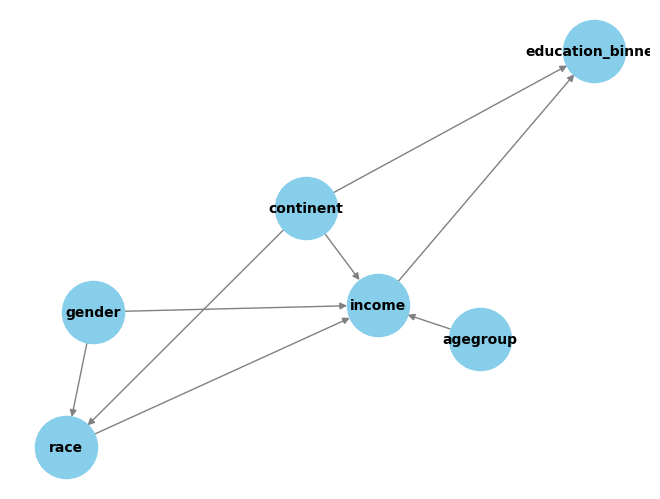

In [124]:
import networkx as nx

# Existing DAG data
dag_data_2 = [
    ('age', 'education_num'),
    ('age', 'hours_per_week'),
    ('age', 'income'),
    ('age', 'income'),
    ('age', 'marital_status'),
    ('age', 'marital_status'),
    ('age', 'occupation'),
    ('age', 'relationship'),
    ('age', 'work_class'),
    ('education_num', 'education'),
    ('education_num', 'hours_per_week'),
    ('education_num', 'income'),
    ('education_num', 'income'),
    ('education_num', 'occupation'),
    ('education_num', 'work_class'),
    ('education_num', 'work_class'),
    ('hours_per_week', 'income'),
    ('hours_per_week', 'relationship'),
    ('income', 'education'),
    ('marital_status', 'education_num'),
    ('marital_status', 'hours_per_week'),
    ('marital_status', 'income'),
    ('marital_status', 'occupation'),
    ('marital_status', 'work_class'),
    ('marital_status', 'work_class'),
    ('native-country', 'education'),
    ('native-country', 'education_num'),
    ('native-country', 'education_num'),
    ('native-country', 'hours_per_week'),
    ('native-country', 'income'),
    ('native-country', 'marital_status'),
    ('native-country', 'occupation'),
    ('native-country', 'race'),
    ('native-country', 'work_class'),
    ('occupation', 'education'),
    ('occupation', 'income'),
    ('occupation', 'occupation_category'),
    ('occupation_category', 'education'),
    ('occupation_category', 'work_class'),
    ('race', 'education_num'),
    ('race', 'hours_per_week'),
    ('race', 'income'),
    ('race', 'income'),
    ('race', 'marital_status'),
    ('race', 'occupation'),
    ('race', 'work_class'),
    ('race', 'work_class'),
    ('gender', 'education_num'),
    ('gender', 'hours_per_week'),
    ('gender', 'income'),
    ('gender', 'income'),
    ('gender', 'marital_status'),
    ('gender', 'occupation'),
    ('gender', 'race'),
    ('gender', 'relationship'),
    ('gender', 'work_class'),
    ('gender', 'work_class'),
    ('work_class', 'income'),
]

# keep only unique tuples
dag_data_2 = list(set(dag_data_2))

relevant_features_2 = ['age', 'gender', 'race', 'native-country', 'income', 'education']
# keep only tupples with both nodes conatained in the features: [age, gender, race, native-country, income]
dag_data_2 = [row for row in dag_data_2 if row[0] in relevant_features_2 and row[1] in relevant_features_2]
# rename native-country to continent and age to agegroup

dag_data_2 = [(row[0].replace('native-country', 'continent').replace('age', 'agegroup').replace('education', 'education_binned'),
             row[1].replace('native-country', 'continent').replace('age', 'agegroup').replace('education', 'education_binned'))
            for row in dag_data_2]

outcome_node = 'income'
treatment_node_to_possible_treatments = {
    'agegroup': ['YoungAdults', 'Adults', 'MiddleAged', 'Senior', 'Kids'],
    'continent': ['North America', 'Central America', 'Asia', 'Europe', 'South America', 'Other'],
    'race': ['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other'],
    'gender': ['Male', 'Female'],
    'education_binned': ['Pre-High School', 'High School', 'Some-college', 'Bachelors', 'Masters', 'Assoc-voc', 'Assoc-acdm', 'Prof-school' 'Doctorate', 'HS-grad']
    # 'income': ['<=50K', '>50K']}
}
# categorical_cols = ['agegroup', 'continent', 'race', 'gender', 'income']
# print()
# # convert the categorical columns to one-hot encoding
# adult_dataset = pd.get_dummies(adult_dataset, columns=categorical_cols, drop_first=True)
# for dag_data_edge in dag_data:
#     if dag_data_edge[0] in categorical_cols:
#         dag_data += [(f'{dag_data_edge[0]}_{treatment}', dag_data_edge[1]) for treatment in treatment_node_to_possible_treatments[dag_data_edge[0]]]
#     if dag_data_edge[1] in categorical_cols:
#         dag_data += [(dag_data_edge[0], f'{dag_data_edge[1]}_{treatment}') for treatment in treatment_node_to_possible_treatments[dag_data_edge[1]]]

# edit the dag to include the one-hot encoded columns
dag = nx.DiGraph(dag_data_2)
print(len(dag.nodes), len(dag.edges))

print(nx.is_directed_acyclic_graph(dag))
# Draw the dag

nx.draw(dag, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray', pos=nx.spring_layout(dag))

In [125]:
#function that changes the dag to take into account the treatment
def causal_dag_manipulation(dag_data, feature_1, feature_2):
    # Replace instances of feature_1 and feature_2 with 'combined_treatment'
    new_dag_data = []
    dag_data = list(dag_data.edges)
    print(dag_data)
    #for edge in dag_data:
    for source, target in dag_data:
        new_source = 'combined_treatment' if source in [feature_1, feature_2] else source
        new_target = 'combined_treatment' if target in [feature_1, feature_2] else target
        if (new_source == new_target): continue
        new_dag_data.append((new_source, new_target))

    # Create a directed graph using NetworkX
    dag_graph = nx.DiGraph()
    dag_graph.add_edges_from(new_dag_data)

    # Plot the new DAG
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(dag_graph)  # Position nodes using spring layout for better visualization
    nx.draw(dag_graph, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10, font_weight='bold', arrows=True)
    plt.title('Modified Causal DAG with Combined Treatment', fontsize=16)
    plt.show()

    # Return the new DAG as a list of edges
    return new_dag_data


In [126]:
# Second Method - look at all values from the treatment feature and, calculate the ATE of each possible Combination to the income feature, using dowhy


def get_two_feature_combination_ate(origin_dataset, dag, feature_1, feature_2):
    # Change the income column to binary
    dataset = origin_dataset.copy()
    print(dataset.head())
    dataset['income'] = dataset['income'].apply(lambda x: 1 if x == '>50K' else -1)

    # Get unique possible values for both features
    possible_values_1 = origin_dataset[feature_1].unique()
    possible_values_2 = origin_dataset[feature_2].unique()

    #new_dag
    new_dag = causal_dag_manipulation(dag, feature_1, feature_2)
    dag = nx.DiGraph(new_dag)

    treatment_to_causal_estimate_dict = {}

    for value_1 in possible_values_1:
        for value_2 in possible_values_2:
            dataset_copy = dataset.copy()
            # Create a new column that is 1 if both features match the specific combination of values, otherwise 0
            dataset_copy['combined_treatment'] = dataset_copy.apply(lambda row: 1 if (row[feature_1] == value_1 and row[feature_2] == value_2) else 0, axis=1)

            # Drop feature_1 and feature_2 columns from the dataset
            dataset_copy = dataset_copy.drop([feature_1, feature_2], axis=1)

            # Print the number of rows where both features match
            print(f'{feature_1}={value_1}, {feature_2}={value_2}: {len(dataset_copy[dataset_copy["combined_treatment"] == 1])}')




            # Causal model
            model = CausalModel(
                data=dataset_copy,
                treatment='combined_treatment',
                outcome='income',
                graph=dag
            )

            # Identify and estimate the effect
            identified_estimand = model.identify_effect()
            causal_estimate = model.estimate_effect(
                identified_estimand,
                method_name="backdoor.linear_regression",
                target_units="ate",
                effect_modifiers=[],
                test_significance=True
            )

            # Check significance
            if is_treatment_significant(causal_estimate):
                print(f'Treatment: {feature_1}={value_1}, {feature_2}={value_2}, ATE: {causal_estimate.value}, p-value: {causal_estimate.test_stat_significance()["p_value"]}')
            else:
                print(f'Treatment: {feature_1}={value_1}, {feature_2}={value_2}, ATE: Not significant {causal_estimate.value}, p-value: {causal_estimate.test_stat_significance()["p_value"]}')

            # Store the result
            treatment_to_causal_estimate_dict[(value_1, value_2)] = causal_estimate
    print(new_dag)

    return treatment_to_causal_estimate_dict

    race  gender income      continent     agegroup education_binned
0  Black    Male  <=50K  North America  YoungAdults      High School
1  White    Male  <=50K  North America       Adults          HS-grad
2  White    Male   >50K  North America  YoungAdults       Assoc-acdm
3  Black    Male   >50K  North America       Adults     Some-college
4  White  Female  <=50K  North America  YoungAdults     Some-college
[('gender', 'income'), ('gender', 'race'), ('income', 'education_binned'), ('continent', 'income'), ('continent', 'race'), ('continent', 'education_binned'), ('race', 'income'), ('agegroup', 'income')]


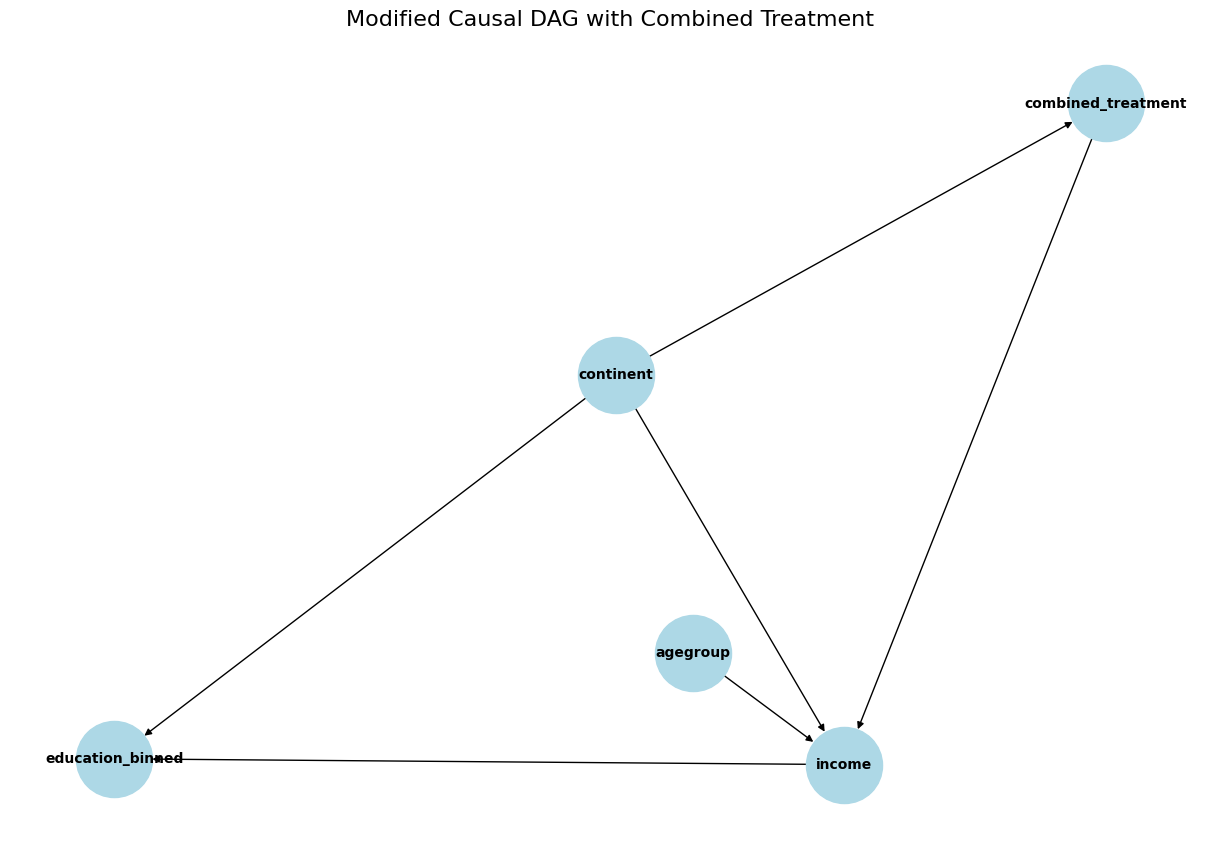

race=Black, gender=Male: 2287
Treatment: race=Black, gender=Male, ATE: -0.11023777004021307, p-value: [1.68780298e-09]
race=Black, gender=Female: 2266
Treatment: race=Black, gender=Female, ATE: -0.3733320533170571, p-value: [4.50147497e-92]
race=White, gender=Male: 28319
Treatment: race=White, gender=Male, ATE: 0.38057787538020177, p-value: [0.]
race=White, gender=Female: 12870
Treatment: race=White, gender=Female, ATE: -0.33108909974080997, p-value: [0.]
race=Other, gender=Male: 238
Treatment: race=Other, gender=Male, ATE: -0.11506356052696654, p-value: [0.03896071]
race=Other, gender=Female: 144
Treatment: race=Other, gender=Female, ATE: -0.2765728434108643, p-value: [0.00010856]
race=Amer-Indian-Eskimo, gender=Male: 285
Treatment: race=Amer-Indian-Eskimo, gender=Male, ATE: -0.2005866115692453, p-value: [7.41592538e-05]
race=Amer-Indian-Eskimo, gender=Female: 185
Treatment: race=Amer-Indian-Eskimo, gender=Female, ATE: -0.3186216728544574, p-value: [3.83603133e-07]
race=Asian-Pac-Isla

{('Black', 'Male'): <dowhy.causal_estimator.CausalEstimate at 0x78b936dac3a0>,
 ('Black',
  'Female'): <dowhy.causal_estimator.CausalEstimate at 0x78b936fb7b20>,
 ('White', 'Male'): <dowhy.causal_estimator.CausalEstimate at 0x78b936dafb20>,
 ('White',
  'Female'): <dowhy.causal_estimator.CausalEstimate at 0x78b934d20970>,
 ('Other', 'Male'): <dowhy.causal_estimator.CausalEstimate at 0x78b935b9afe0>,
 ('Other',
  'Female'): <dowhy.causal_estimator.CausalEstimate at 0x78b935b9b5e0>,
 ('Amer-Indian-Eskimo',
  'Male'): <dowhy.causal_estimator.CausalEstimate at 0x78b9353cbe50>,
 ('Amer-Indian-Eskimo',
  'Female'): <dowhy.causal_estimator.CausalEstimate at 0x78b9357340d0>,
 ('Asian-Pac-Islander',
  'Male'): <dowhy.causal_estimator.CausalEstimate at 0x78b936ecfc70>,
 ('Asian-Pac-Islander',
  'Female'): <dowhy.causal_estimator.CausalEstimate at 0x78b936fb7550>}

In [127]:
get_two_feature_combination_ate(adult_dataset_2, dag, 'race', 'gender')

In [128]:
import matplotlib.pyplot as plt

def plot_ate_bar(treatment_to_causal_estimate_dict_synthesized, treatment_to_causal_estimate_dict_original, feature_1, feature_2):
    treatments = list(treatment_to_causal_estimate_dict_synthesized.keys())

    synthesized_ates = [abs(treatment_to_causal_estimate_dict_synthesized[treatment].value) for treatment in treatments]
    original_ates = [abs(treatment_to_causal_estimate_dict_original[treatment].value) for treatment in treatments]

    labels = [f'{feature_1}={treatment[0]}, {feature_2}={treatment[1]}' for treatment in treatments]

    # Set up the bar plot
    x = range(len(treatments))
    width = 0.35  # Bar width

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot original ATEs
    ax.bar(x, original_ates, width, label='Original ATE', color='lightblue', edgecolor='black')

    # Plot synthesized ATEs, with some offset
    ax.bar([i + width for i in x], synthesized_ates, width, label='Synthesized ATE', color='salmon', edgecolor='black')

    # Add labels and title
    ax.set_xlabel('Treatments')
    ax.set_ylabel('ATE')
    ax.set_title(f'Comparison of Original and Synthesized ATEs for {feature_1} and {feature_2}')
    ax.set_xticks([i + width / 2 for i in x])
    ax.set_xticklabels(labels, rotation=90)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


In [129]:
def check_synthesized_samples_effect_two_features(dataset, dag, feature_1, feature_2, synthesized_samples_file_path):
    # Load the synthesized samples csv
    synthesized_samples = pd.read_csv(synthesized_samples_file_path)

    # Take only the relevant features from synthesized samples
    synthesized_samples = synthesized_samples[[col for col in synthesized_samples.columns if col in dataset.columns]]

    # Combine the original dataset and synthesized samples
    data = dataset.copy()
    data = pd.concat([data, synthesized_samples])

    data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else -1)


    # Get unique possible values for both features
    possible_values_1 = data[feature_1].unique()
    possible_values_2 = data[feature_2].unique()

    # Dictionary to store causal estimates for synthesized data
    treatment_to_causal_estimate_dict_synthesized = {}

    # Modify DAG to combine the two features
    new_dag = causal_dag_manipulation(dag, feature_1, feature_2)
    dag = nx.DiGraph(new_dag)


    for value_1 in possible_values_1:
        for value_2 in possible_values_2:
            data_copy = data.copy()
            # Create a new column that is 1 if both features match the specific combination of values, otherwise 0
            data_copy['combined_treatment'] = data_copy.apply(lambda row: 1 if (row[feature_1] == value_1 and row[feature_2] == value_2) else 0, axis=1)

            # Drop the original feature_1 and feature_2 columns
            data_copy = data_copy.drop([feature_1, feature_2], axis=1)



            # Causal model
            model = CausalModel(
                data=data_copy,
                treatment='combined_treatment',
                outcome='income',
                graph=dag
            )

            # Identify and estimate the effect
            identified_estimand = model.identify_effect()
            causal_estimate = model.estimate_effect(
                identified_estimand,
                method_name="backdoor.linear_regression",
                target_units="ate",
                effect_modifiers=[],
                test_significance=True
            )

            # Store the result in the dictionary
            treatment_to_causal_estimate_dict_synthesized[(value_1, value_2)] = causal_estimate

    # Compare synthesized sample results with original ATEs
    treatment_to_causal_estimate_dict_original = get_two_feature_combination_ate(dataset, dag, feature_1, feature_2)

    for treatment, causal_estimate_synthesized in treatment_to_causal_estimate_dict_synthesized.items():
        print(f'Treatment: {feature_1}={treatment[0]}, {feature_2}={treatment[1]}, ATE (Synthesized): {causal_estimate_synthesized.value}')
        print(f'Actual ATE: {treatment_to_causal_estimate_dict_original[treatment].value}')
        print(f'Error: {abs(causal_estimate_synthesized.value - treatment_to_causal_estimate_dict_original[treatment].value)}')
    print(treatment_to_causal_estimate_dict_synthesized)
    # Calculate and print the treatment with the highest error
    errors = [abs(causal_estimate_synthesized.value - treatment_to_causal_estimate_dict_original[treatment].value)
              for treatment, causal_estimate_synthesized in treatment_to_causal_estimate_dict_synthesized.items()
              if is_treatment_significant(causal_estimate_synthesized) and is_treatment_significant(treatment_to_causal_estimate_dict_original[treatment])]


    if errors:
        max_error = max(errors)
        errors_without_max = [e for e in errors if e != max_error]
        if (len(errors_without_max)>=1):
          print(f'Second Max: {max(errors_without_max)}')


        min_error = min(errors)
        print(f'Max error: {max_error}')
        print(f'Treatment with max error: {[treatment for treatment, causal_estimate_synthesized in treatment_to_causal_estimate_dict_synthesized.items() if abs(causal_estimate_synthesized.value - treatment_to_causal_estimate_dict_original[treatment].value) == max_error]}')

        print(f'Min error: {min_error}')
        print(f'Treatment with min error: {[treatment for treatment, causal_estimate_synthesized in treatment_to_causal_estimate_dict_synthesized.items() if abs(causal_estimate_synthesized.value - treatment_to_causal_estimate_dict_original[treatment].value) == min_error]}')

        print(f'Mean error: {np.mean(errors)}')
    else:
        print("No significant treatments found.")

    plot_ate_bar(treatment_to_causal_estimate_dict_synthesized, treatment_to_causal_estimate_dict_original, feature_1, feature_2)


[('gender', 'income'), ('gender', 'race'), ('income', 'education_binned'), ('continent', 'income'), ('continent', 'race'), ('continent', 'education_binned'), ('race', 'income'), ('agegroup', 'income')]


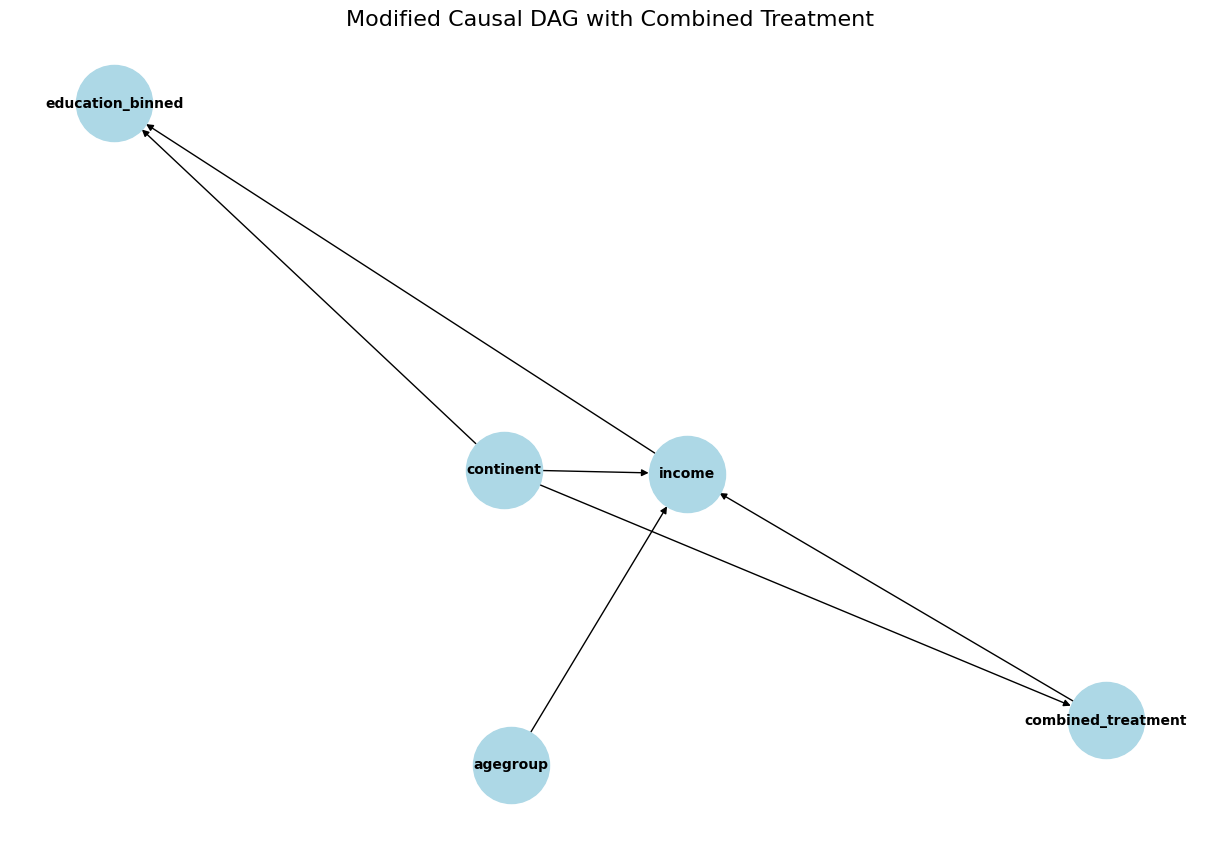

    race  gender income      continent     agegroup education_binned
0  Black    Male  <=50K  North America  YoungAdults      High School
1  White    Male  <=50K  North America       Adults          HS-grad
2  White    Male   >50K  North America  YoungAdults       Assoc-acdm
3  Black    Male   >50K  North America       Adults     Some-college
4  White  Female  <=50K  North America  YoungAdults     Some-college
[('combined_treatment', 'income'), ('income', 'education_binned'), ('continent', 'income'), ('continent', 'combined_treatment'), ('continent', 'education_binned'), ('agegroup', 'income')]


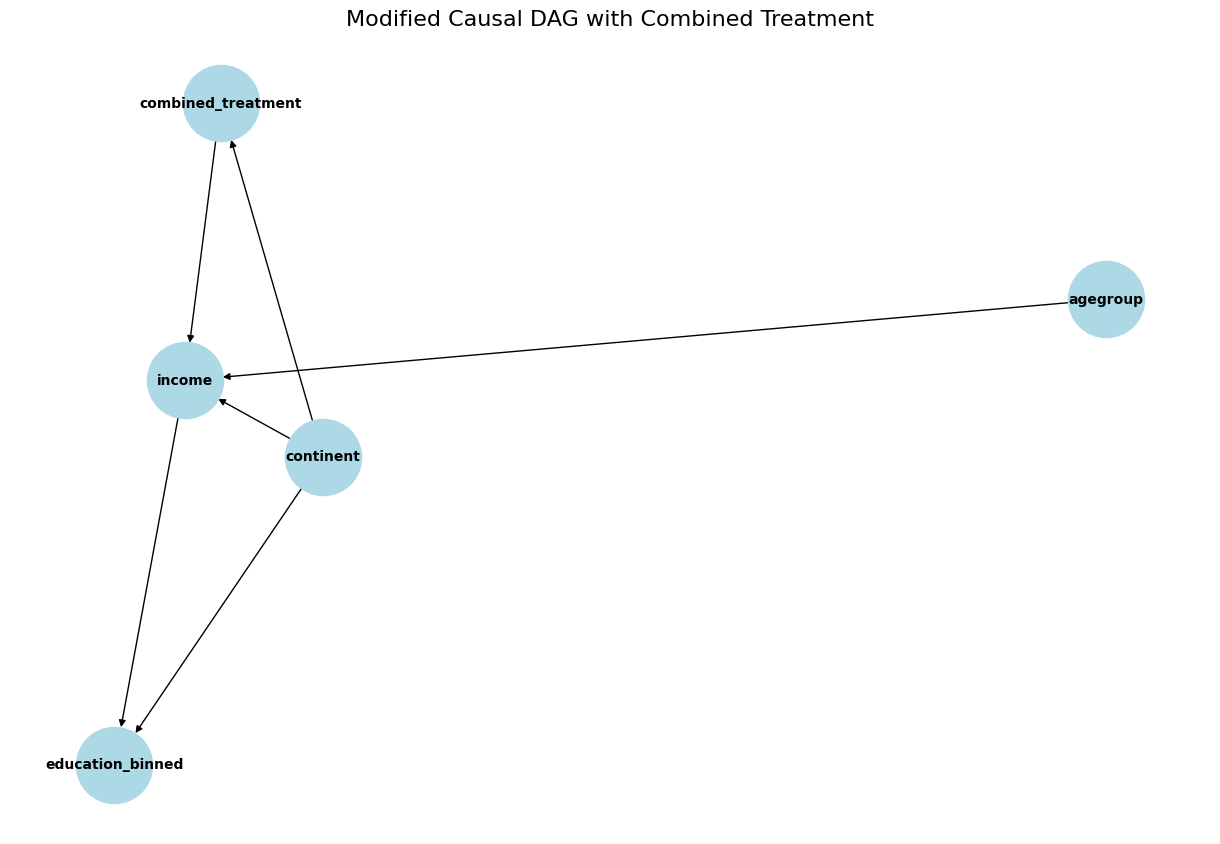

race=Black, gender=Male: 2287
Treatment: race=Black, gender=Male, ATE: -0.11023777004021307, p-value: [1.68780298e-09]
race=Black, gender=Female: 2266
Treatment: race=Black, gender=Female, ATE: -0.3733320533170571, p-value: [4.50147497e-92]
race=White, gender=Male: 28319
Treatment: race=White, gender=Male, ATE: 0.38057787538020177, p-value: [0.]
race=White, gender=Female: 12870
Treatment: race=White, gender=Female, ATE: -0.33108909974080997, p-value: [0.]
race=Other, gender=Male: 238
Treatment: race=Other, gender=Male, ATE: -0.11506356052696654, p-value: [0.03896071]
race=Other, gender=Female: 144
Treatment: race=Other, gender=Female, ATE: -0.2765728434108643, p-value: [0.00010856]
race=Amer-Indian-Eskimo, gender=Male: 285
Treatment: race=Amer-Indian-Eskimo, gender=Male, ATE: -0.2005866115692453, p-value: [7.41592538e-05]
race=Amer-Indian-Eskimo, gender=Female: 185
Treatment: race=Amer-Indian-Eskimo, gender=Female, ATE: -0.3186216728544574, p-value: [3.83603133e-07]
race=Asian-Pac-Isla

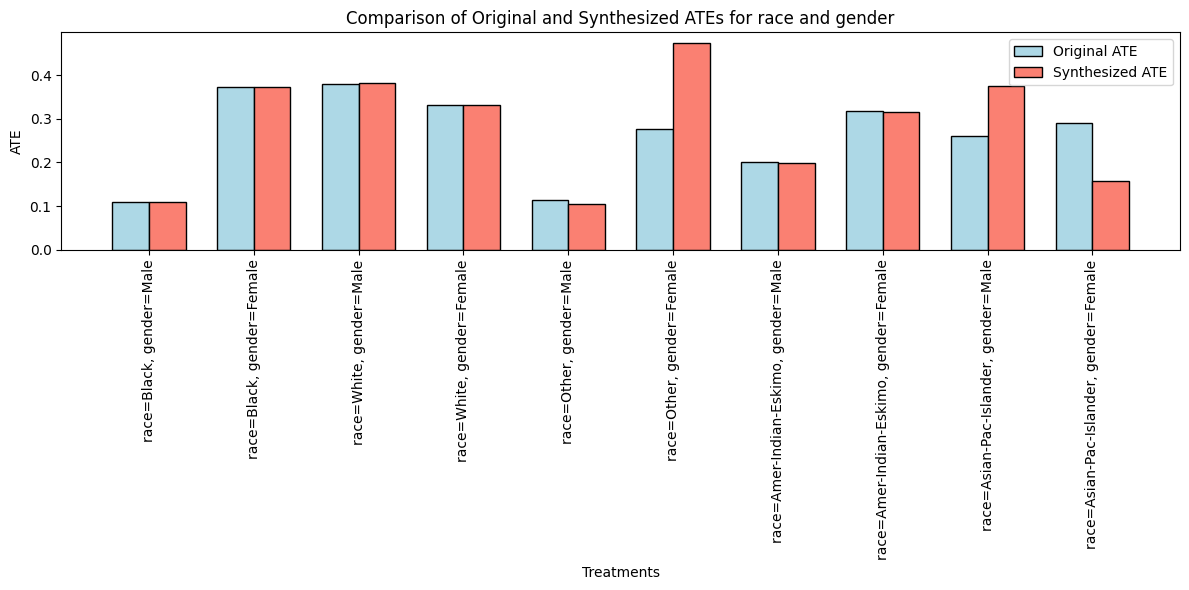

In [130]:
synthesized_samples_file_path = f'./synthesized_samples_other_females.csv'
check_synthesized_samples_effect_two_features(adult_dataset_2, dag, 'race', 'gender', synthesized_samples_file_path)


[('gender', 'income'), ('gender', 'race'), ('continent', 'income'), ('continent', 'race'), ('continent', 'education_binned'), ('race', 'income'), ('agegroup', 'income')]
    race  gender income      continent     agegroup education_binned
0  Black    Male  <=50K  North America  YoungAdults      High School
1  White    Male  <=50K  North America       Adults          HS-grad
2  White    Male   >50K  North America  YoungAdults       Assoc-acdm
3  Black    Male   >50K  North America       Adults     Some-college
4  White  Female  <=50K  North America  YoungAdults     Some-college
[('gender', 'income'), ('gender', 'race'), ('race', 'income'), ('continent', 'income'), ('continent', 'race'), ('continent', 'education_binned'), ('agegroup', 'income')]


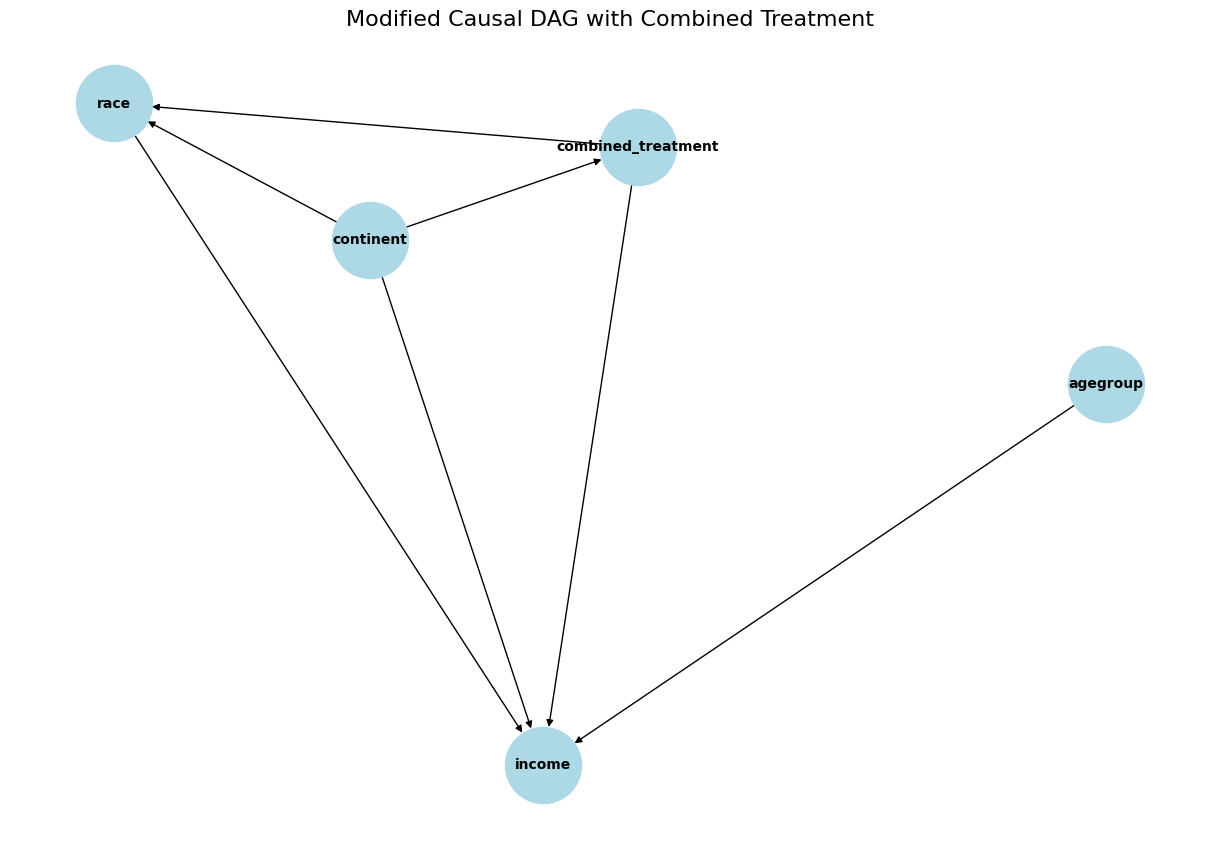

education_binned=High School, gender=Male: 3023
Treatment: education_binned=High School, gender=Male, ATE: 0.14925860802110963, p-value: [1.08579539e-20]
education_binned=High School, gender=Female: 1506
Treatment: education_binned=High School, gender=Female, ATE: -0.27045922168931624, p-value: [7.03997186e-34]
education_binned=HS-grad, gender=Male: 10407
Treatment: education_binned=HS-grad, gender=Male, ATE: 0.1580835679720074, p-value: [3.82398425e-63]
education_binned=HS-grad, gender=Female: 5132
Treatment: education_binned=HS-grad, gender=Female, ATE: -0.29014840142524434, p-value: [3.18445492e-118]
education_binned=Assoc-acdm, gender=Male: 1049
Treatment: education_binned=Assoc-acdm, gender=Male, ATE: 0.12897387485470796, p-value: [1.24014455e-06]
education_binned=Assoc-acdm, gender=Female: 519
Treatment: education_binned=Assoc-acdm, gender=Female, ATE: -0.28452817612908265, p-value: [3.76989049e-14]
education_binned=Some-college, gender=Male: 7151
Treatment: education_binned=Some

{('High School',
  'Male'): <dowhy.causal_estimator.CausalEstimate at 0x78b936f01ae0>,
 ('High School',
  'Female'): <dowhy.causal_estimator.CausalEstimate at 0x78b9356cb3a0>,
 ('HS-grad',
  'Male'): <dowhy.causal_estimator.CausalEstimate at 0x78b936f03820>,
 ('HS-grad',
  'Female'): <dowhy.causal_estimator.CausalEstimate at 0x78b9357bef20>,
 ('Assoc-acdm',
  'Male'): <dowhy.causal_estimator.CausalEstimate at 0x78b935563940>,
 ('Assoc-acdm',
  'Female'): <dowhy.causal_estimator.CausalEstimate at 0x78b935c580d0>,
 ('Some-college',
  'Male'): <dowhy.causal_estimator.CausalEstimate at 0x78b935c5bd60>,
 ('Some-college',
  'Female'): <dowhy.causal_estimator.CausalEstimate at 0x78b9355607c0>,
 ('Prof-school',
  'Male'): <dowhy.causal_estimator.CausalEstimate at 0x78b935bbba60>,
 ('Prof-school',
  'Female'): <dowhy.causal_estimator.CausalEstimate at 0x78b9357d94e0>,
 ('Pre-High School',
  'Male'): <dowhy.causal_estimator.CausalEstimate at 0x78b9357d8310>,
 ('Pre-High School',
  'Female'): <do

In [145]:
#Now We want weight for female doctorate and female prof-school
dag = list(dag.edges)
filtered_dag = [(row[0], row[1]) for row in dag if row[0] != 'income']
print(filtered_dag)
filtered_dag = nx.DiGraph(filtered_dag)
#dag = dag[(edge1,edge2) for edge1, edge2 in dag.items() if edge1 != 'income']
get_two_feature_combination_ate(adult_dataset_2, filtered_dag, 'education_binned', 'gender')

[('gender', 'income'), ('gender', 'race'), ('race', 'income'), ('continent', 'income'), ('continent', 'race'), ('continent', 'education_binned'), ('agegroup', 'income')]


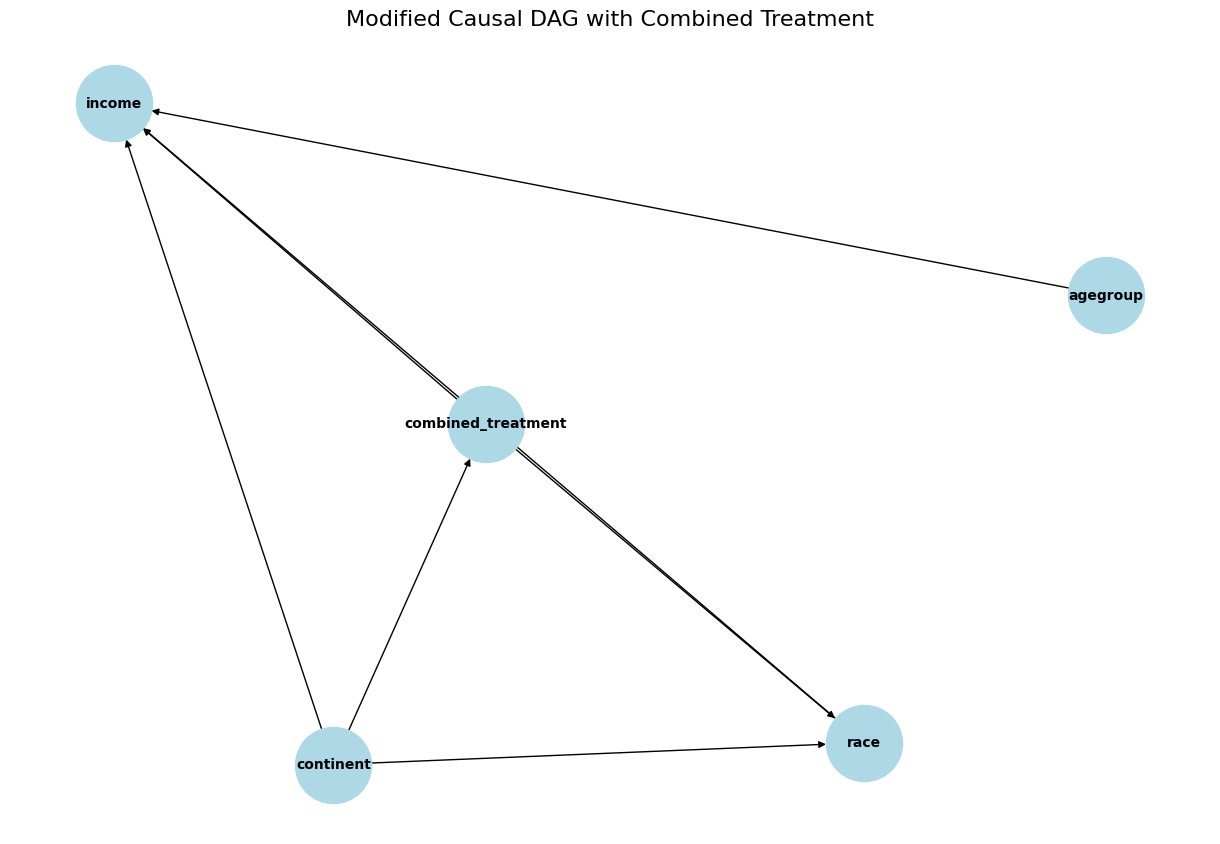

    race  gender income      continent     agegroup education_binned
0  Black    Male  <=50K  North America  YoungAdults      High School
1  White    Male  <=50K  North America       Adults          HS-grad
2  White    Male   >50K  North America  YoungAdults       Assoc-acdm
3  Black    Male   >50K  North America       Adults     Some-college
4  White  Female  <=50K  North America  YoungAdults     Some-college
[('combined_treatment', 'income'), ('combined_treatment', 'race'), ('race', 'income'), ('continent', 'income'), ('continent', 'race'), ('continent', 'combined_treatment'), ('agegroup', 'income')]


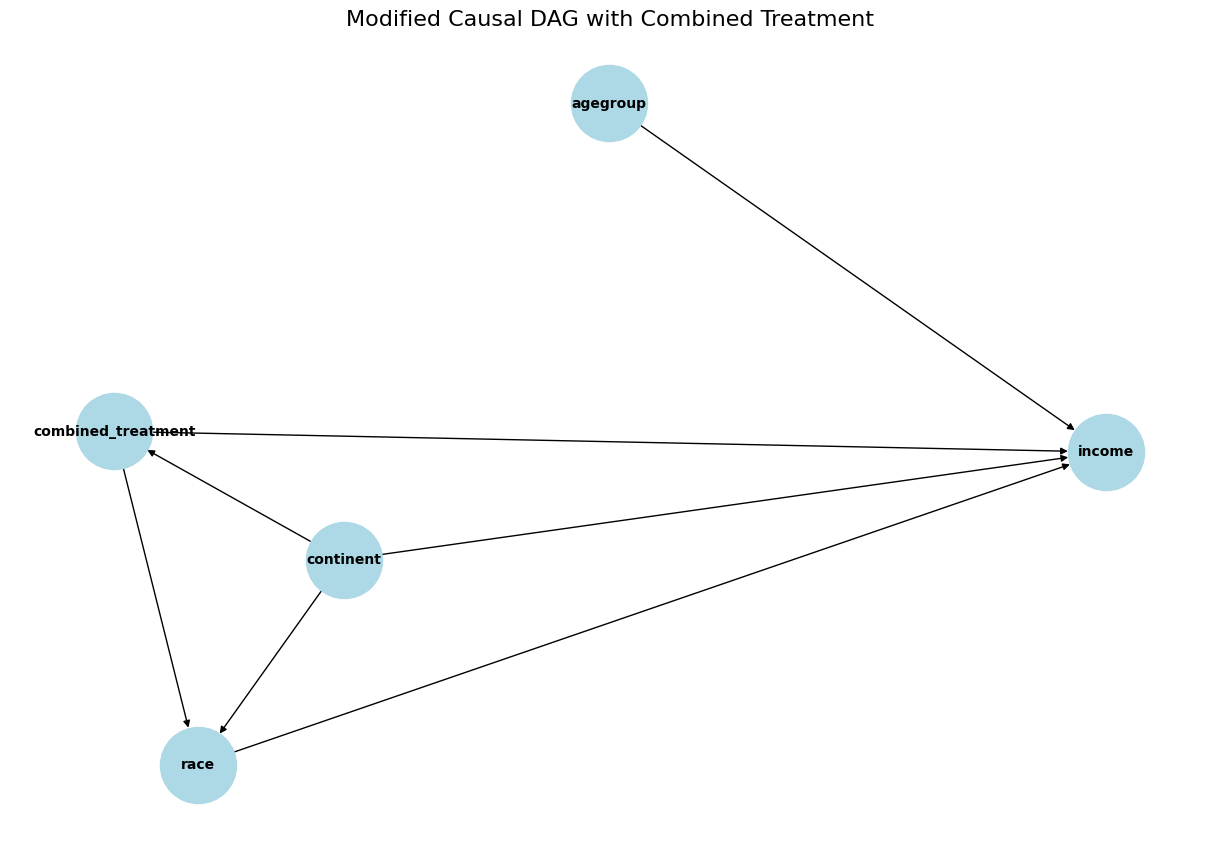

education_binned=High School, gender=Male: 3023
Treatment: education_binned=High School, gender=Male, ATE: 0.14925860802110963, p-value: [1.08579539e-20]
education_binned=High School, gender=Female: 1506
Treatment: education_binned=High School, gender=Female, ATE: -0.27045922168931624, p-value: [7.03997186e-34]
education_binned=HS-grad, gender=Male: 10407
Treatment: education_binned=HS-grad, gender=Male, ATE: 0.1580835679720074, p-value: [3.82398425e-63]
education_binned=HS-grad, gender=Female: 5132
Treatment: education_binned=HS-grad, gender=Female, ATE: -0.29014840142524434, p-value: [3.18445492e-118]
education_binned=Assoc-acdm, gender=Male: 1049
Treatment: education_binned=Assoc-acdm, gender=Male, ATE: 0.12897387485470796, p-value: [1.24014455e-06]
education_binned=Assoc-acdm, gender=Female: 519
Treatment: education_binned=Assoc-acdm, gender=Female, ATE: -0.28452817612908265, p-value: [3.76989049e-14]
education_binned=Some-college, gender=Male: 7151
Treatment: education_binned=Some

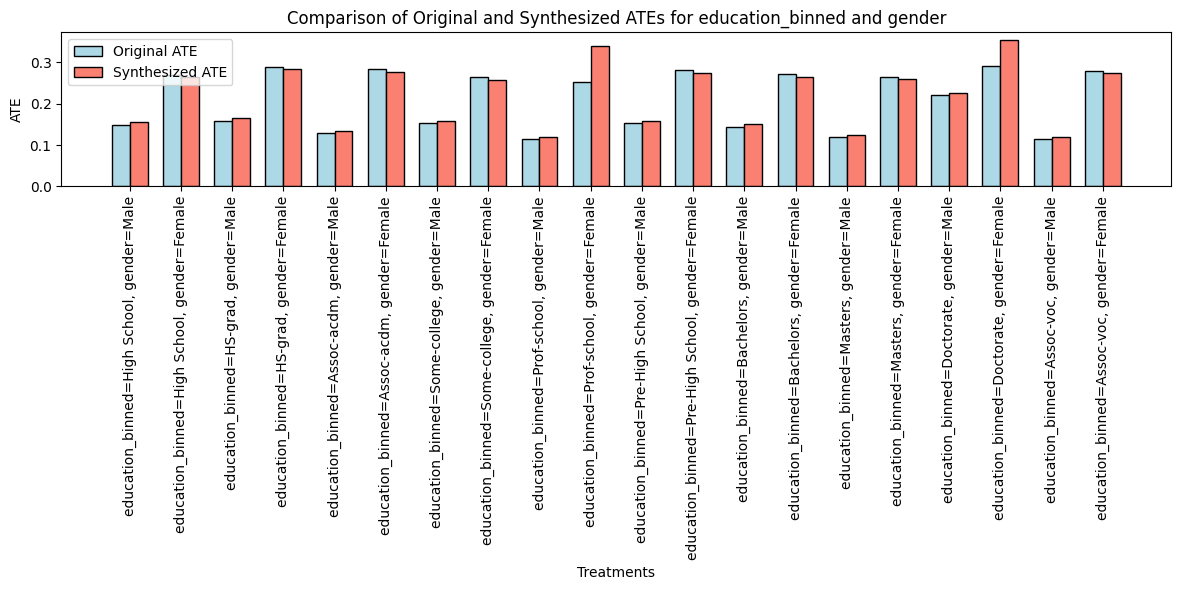

In [148]:
synthesized_samples_file_path = f'./synthesized_samples_Females_education.csv'
check_synthesized_samples_effect_two_features(adult_dataset_2, filtered_dag, 'education_binned', 'gender', synthesized_samples_file_path)

In [225]:
#Basic Model Assessment
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score


np.random.seed(42)
accuracy_overall_model = {}

columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
           'hours-per-week', 'native-country', 'income']
original_data = pd.read_csv('./adult.csv')


original_data = pd.get_dummies(original_data, drop_first=True)

# Separate features and target variable
print(original_data.columns)

X = original_data.drop('income_>50K', axis=1)  # Adjusting target column after one-hot encoding
y = original_data['income_>50K']  # Target variable: 1 if >50K, 0 if <=50K

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train a logistic regression model
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy_overall_model['original'] = accuracy
print(f"Accuracy: {accuracy}")



Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private',
       ...
       'native-country_Puerto-Rico', 'native-country_Scotland',
       'native-country_South', 'native-country_Taiwan',
       'native-country_Thailand', 'native-country_Trinadad&Tobago',
       'native-country_United-States', 'native-country_Vietnam',
       'native-country_Yugoslavia', 'income_>50K'],
      dtype='object', length=101)
Accuracy: 0.8036646534957519


In [234]:
underrepresented_groups = ['Female_Asian-Pac-Islander', 'other_females']
feature1 = ['gender', 'gender']
feature2 = ['race', 'race']
value1 = ['Male', 'Male']
value2 = ['Asian-Pac-Islander', 'Other']
for index in range(len(underrepresented_groups)):

  string1 = f'{feature1[index]}_{value1[index]}'
  string2 = f'{feature2[index]}_{value2[index]}'
  filter_data = (X_test[string1] == 0) & (X_test[string2] == 1)

  X_filtered = X_test[filter_data]
  y_filtered = y_test[filter_data]
  y_pred_filtered_original = model.predict(X_filtered)



  accuracy_filtered_original = accuracy_score(y_filtered, y_pred_filtered_original)
  print(f"Accuracy for Original dataset - underrepresented: {accuracy_filtered_original}")
  original_underrepresented[underrepresented_groups[index]] = accuracy_filtered_original

Accuracy for Original dataset - underrepresented: 0.9381443298969072
Accuracy for Original dataset - underrepresented: 0.9615384615384616


In [237]:
def calc_dataset_accuracy(original_dataset, synthesized_dataset, underrep_string,  feature1 ,feature2, value1, value2, original_model, original_underrepresented, augmented_underrepresented, accuracy_overall_model):

    # Take only the relevant features from synthesized samples

    original_dataset = original_dataset.drop('educational-num', axis=1)

    new_dataset = synthesized_dataset[[col for col in synthesized_dataset.columns if col in original_dataset.columns]]


    #print(f'Underrepresented Group: {value1} and {value2}')

    # Combine the original dataset and synthesized samples
    augmented_dataset = original_dataset.copy()
    augmented_dataset = pd.concat([augmented_dataset, new_dataset])
    augmented_dataset = pd.get_dummies(augmented_dataset, drop_first=True)

    # Separate features and target variable



    X = augmented_dataset.drop('income_>50K', axis=1)  # Adjusting target column after one-hot encoding
    y = augmented_dataset['income_>50K']  # Target variable: 1 if >50K, 0 if <=50K

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rows_with_nan = X_train[X_train.isna().any(axis=1)]
    print(rows_with_nan)

    # Train a logistic regression model
    model = LogisticRegression(max_iter=200)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_overall_model[underrep_string] = accuracy
    print(f"Accuracy: {accuracy}")

    string1 = f'{feature1}_{value1}'
    string2 = f'{feature2}_{value2}'

    #filter for underrepresented accuracy test - see comperison between original dataset
    filter_data = (X_test[string1] == 0) & (X_test[string2] == 1)

    X_filtered = X_test[filter_data]
    y_filtered = y_test[filter_data]
    y_pred_filtered_augmented = model.predict(X_filtered)
    #y_pred_filtered_original = original_model.predict(X_filtered)



    #accuracy_filtered_original = accuracy_score(y_filtered, y_pred_filtered_original)
    #print(f"Accuracy for Original dataset - underrepresented: {accuracy_filtered_original}")
    accuracy_filtered_augmented = accuracy_score(y_filtered, y_pred_filtered_augmented)
    print(f"Accuracy for Augmented dataset - underrepresented: {accuracy_filtered_augmented}")
    return accuracy_filtered_augmented





In [239]:
np.random.seed(42)

#add dictinaties for accuracy comperisons

columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
           'hours-per-week', 'native-country', 'income']

accuracy_overall_model['original'] = accuracy
print(accuracy_overall_model)


original_data = pd.read_csv('./adult.csv')
# Dictionary to map column names from synthesized_dataset to match those in original_data
rename_columns = {
    'race': 'race',
    'gender': 'gender',
    'age': 'age',
    'education': 'education',
    'marital-status': 'marital_status',
    'workclass': 'work_class',
    'occupation': 'occupation',
    'hours-per-week': 'hours_per_week',
    'native-country': 'native_country',
    'fnlwgt': 'fnlwgt',
    'capital-gain': 'capital_gain',
    'capital-loss': 'capital_loss',
    # 'income' is not in synthesized_dataset columns; add it if needed.
    # Drop columns like 'educational-num', if they don't exist in the original dataset.
}

# Rename the columns in synthesized_dataset to match original_data
original_data.rename(columns=rename_columns, inplace=True)

# Now the columns in synthesized_dataset should match original_data
print(original_data.columns)

underrepresented_groups = ['Female_Asian-Pac-Islander', 'other_females']
feature1 = ['gender', 'gender']
feature2 = ['race', 'race']
value1 = ['Male', 'Male']
value2 = ['Asian-Pac-Islander', 'Other']
for index in range(len(underrepresented_groups)):
  print(index)
  synthesized_samples_file_path = f'./synthesized_samples_{underrepresented_groups[index]}.csv'
  synthesized_samples = pd.read_csv(synthesized_samples_file_path)

  augmented_underrepresented[underrepresented_groups[index]] = calc_dataset_accuracy(original_data, synthesized_samples, underrepresented_groups[index], feature1[index] ,feature2[index], value1[index], value2[index], model, original_underrepresented, augmented_underrepresented, accuracy_overall_model)

{'original': 0.8036646534957519, 'Female_Asian-Pac-Islander': 0.7993704944664433}
Index(['age', 'work_class', 'fnlwgt', 'education', 'educational-num',
       'marital_status', 'occupation', 'relationship', 'race', 'gender',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')
0
Empty DataFrame
Columns: [age, fnlwgt, capital_gain, capital_loss, hours_per_week, work_class_Federal-gov, work_class_Local-gov, work_class_Never-worked, work_class_Private, work_class_Self-emp-inc, work_class_Self-emp-not-inc, work_class_State-gov, work_class_Without-pay, education_11th, education_12th, education_1st-4th, education_5th-6th, education_7th-8th, education_9th, education_Assoc-acdm, education_Assoc-voc, education_Bachelors, education_Doctorate, education_HS-grad, education_Masters, education_Preschool, education_Prof-school, education_Some-college, marital_status_Married-AF-spouse, marital_status_Married-civ-spouse, marital_status_Marri

In [240]:
print(accuracy_overall_model)
print(augmented_underrepresented)
print(original_underrepresented)

{'original': 0.8036646534957519, 'Female_Asian-Pac-Islander': 0.7993704944664433, 'other_females': 0.7975478771912048}
{'Female_Asian-Pac-Islander': 0.654054054054054, 'other_females': 0.6456692913385826}
{'Female_Asian-Pac-Islander': 0.9381443298969072, 'other_females': 0.9615384615384616}


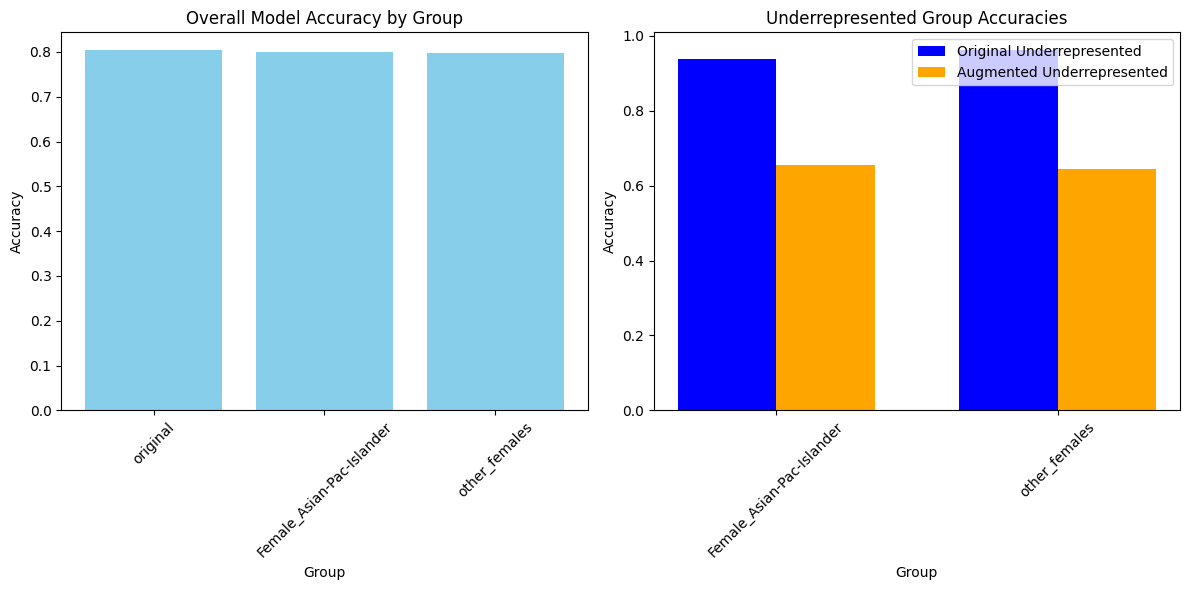

In [241]:
import matplotlib.pyplot as plt

# Function to create two bar plots: one for accuracy_overall_model and one for augmented vs original underrepresented
def plot_accuracy_bars(accuracy_overall_model, augmented_underrepresented, original_underrepresented):
    # First bar plot for accuracy_overall_model
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(accuracy_overall_model.keys(), accuracy_overall_model.values(), color='skyblue')
    plt.xlabel('Group')
    plt.ylabel('Accuracy')
    plt.title('Overall Model Accuracy by Group')
    plt.xticks(rotation=45)

    # Second bar plot for original vs augmented underrepresented groups
    plt.subplot(1, 2, 2)
    bar_width = 0.35
    index = range(len(original_underrepresented))

    # Plot original and augmented underrepresented accuracies
    plt.bar(index, original_underrepresented.values(), bar_width, label='Original Underrepresented', color='blue')
    plt.bar([i + bar_width for i in index], augmented_underrepresented.values(), bar_width, label='Augmented Underrepresented', color='orange')

    plt.xlabel('Group')
    plt.ylabel('Accuracy')
    plt.title('Underrepresented Group Accuracies')
    plt.xticks([i + bar_width / 2 for i in index], original_underrepresented.keys(), rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_accuracy_bars(accuracy_overall_model, augmented_underrepresented, original_underrepresented)


In [ ]:
europe_white_filter = (X_test['race_White'] == 1) & (X_test['continent_Europe'] == 1)

# Filter the test set for Asian and White people
X_europe_white = X_test[europe_white_filter]
y_europe_white = y_test[europe_white_filter]

print(X_europe_white.shape[0])
print(X_europe_white.columns)

# Predict for Asian and White people
y_pred_europe_white = model.predict(X_europe_white)

# Calculate accuracy for Asian and White people
accuracy_europe_white = accuracy_score(y_europe_white, y_pred_europe_white)
print(f"Accuracy for Europian White people: {accuracy_europe_white}")
